In [39]:
import ee
from drought.data import ee_climate, pipeline
from drought.visualization import plot
import drought.data.df_extensions as dfext
import drought.data.seasonal as seasonal
import drought.data.interpolate as interpolate
import geemap
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from scipy import fftpack
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.dates as mdates

import importlib
importlib.reload(seasonal)
importlib.reload(plot)
importlib.reload(interpolate)

<module 'drought.data.interpolate' from '/Users/jovanaknezevic/drought-with-gedi/drought/data/interpolate.py'>

In [2]:
ee.Initialize()

### Load climate and GEDI data

This data has been pre-generated and saved in CSV files. For GEDI data generation, take a look at GEDIDataProcessing notebook. For climate data generation, look at the bottom sections of this notebook.

In [51]:
climate = pd.read_csv('../../data/interim/all_climate_monthly_mean_5000_scale_2001_to_2023.csv', index_col=0)
gedi = pd.read_csv('../../data/interim/gedi_monthly_extended_interpolated_March_11.csv', index_col=0)

# This is the data used in the previous seasonality calculations, saving here in case we need it again.
#climate = pd.read_csv('../../data/interim/monthly_means_timeseries_of_climate_vars_01-2010_to_11-2022.csv', index_col=0)
#gedi = pd.read_csv("../../data/interim/gedi_monthly_interpolated_via_weighted_average.csv", index_col=0)


In [58]:
# Dates of interest, inclusive.
climate_start_date = '2001-01-01'
climate_end_date = '2022-05-01'
climate_columns = ['precipitation', 'temperature', 'radiation', 'fpar',
                   'P-PET', 'PET']

# GEDI data is only available in the 2019-2022 range.
gedi_start_date = '2019-05-01'
gedi_end_date = '2022-05-01'

In [59]:
# Limit GEDI range to matches the dates above, to avoid NaN values in the interpolated PAI values.
gedi = gedi[(gedi.datetime >= gedi_start_date) & (gedi.datetime <= gedi_end_date)]

# Cutoff climate data until the gedi end date as well, both because having climate data later is useless, and because we've seen weird radiation values in September and October of 2022.
climate = climate[climate.datetime <= gedi_end_date]

## Seasonal Decomposition

For both climate and vegetation timeseries, we will run seasonal decomposition to break down each timeseries into three components - seasonal, trend and reminder. We do this using STL method from ```statsmodels.tsa.seasonal``` library.

In this section, we focus on looking at seasonal components only. 

In [60]:
# Some climate data is missing in individual months, mostly fpar and temperature in some of the moist regions (polygons 1 and 2).
# We linearly interpolate each climate column, because NaN values will prevent us from doing seasonal decomposition.
climate = interpolate.interpolate_using_linear(climate, climate_columns)

# Gedi data has already been interpolated using weighted averages. 
# However, polygon 3 still has missing data, so we use linear interpolation to 
# fill the gaps - but polygon 3 shoult not really be used as the data quality 
# is bad - i.e. we don't have enough data for timeseries analysis.
gedi = interpolate.interpolate_using_linear(gedi, ['pai'])

<AxesSubplot: xlabel='date', ylabel='precipitation'>

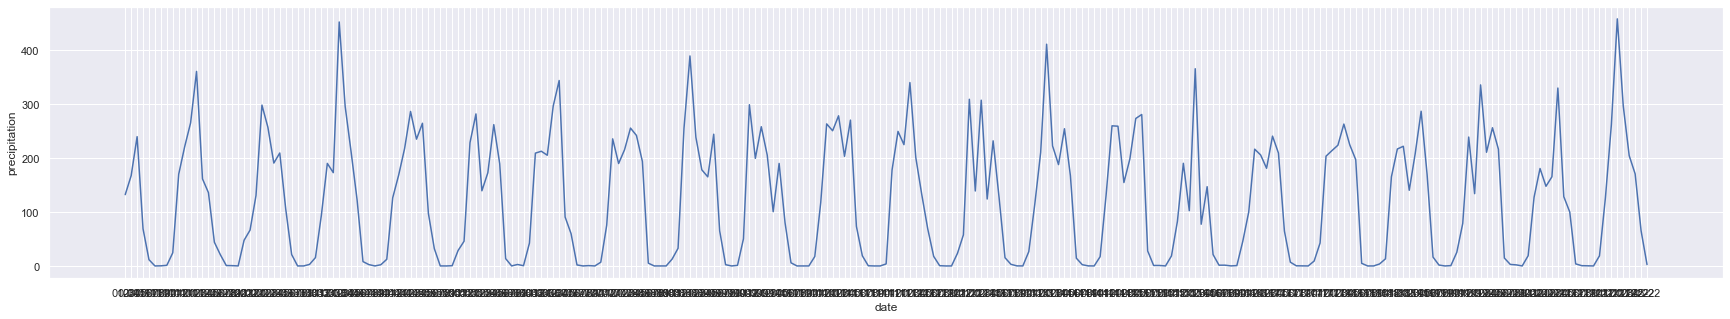

In [61]:
# Quick plot to visualize each climate parameter. You can substitute polygon_id and y = column name of a climate variable of interest.
plt.rcParams['figure.figsize'] = [30, 5]
sns.lineplot(climate[(climate.polygon_id==6)], x='date', y='precipitation')

<AxesSubplot: xlabel='datetime', ylabel='pai'>

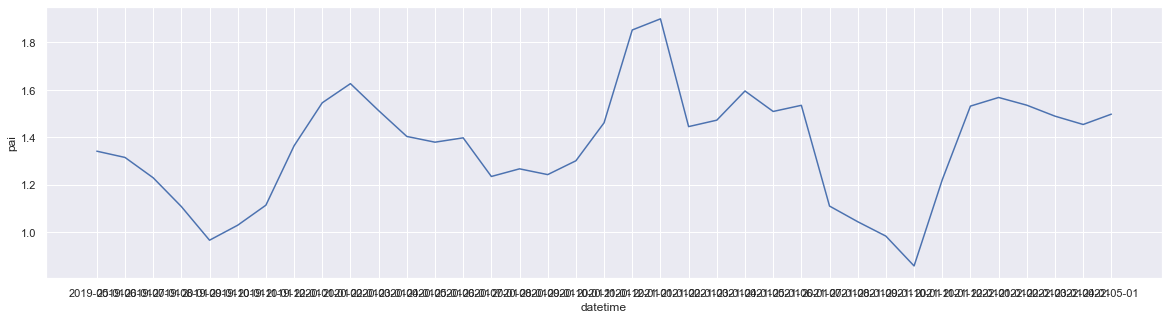

In [62]:
# Quick plot to visualize each climate parameter. You can substitute polygon_id and y = column name of a climate variable of interest.
plt.rcParams['figure.figsize'] = [20, 5]
sns.lineplot(gedi[gedi.polygon_id==8], x='datetime', y='pai')

In [63]:
# Do seasonal decomp.
climate_seasonal = seasonal.get_ts_seasonal_component_per_polygon(climate, climate_start_date, climate_end_date, columns=climate_columns)
gedi_seasonal = seasonal.get_ts_seasonal_component_per_polygon(gedi, gedi_start_date, gedi_end_date, columns=['pai', 'rh100'])

#### Plot Seasonal vs. Original signal

In [64]:
climate['datetime'] = climate.datetime.astype(np.datetime64)

In [65]:
def format_date(ax):
    for row in ax:
        for axis in row:
            locator = mdates.AutoDateLocator(minticks=10, maxticks=17)
            axis.xaxis.set_major_locator(locator) 
            axis.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

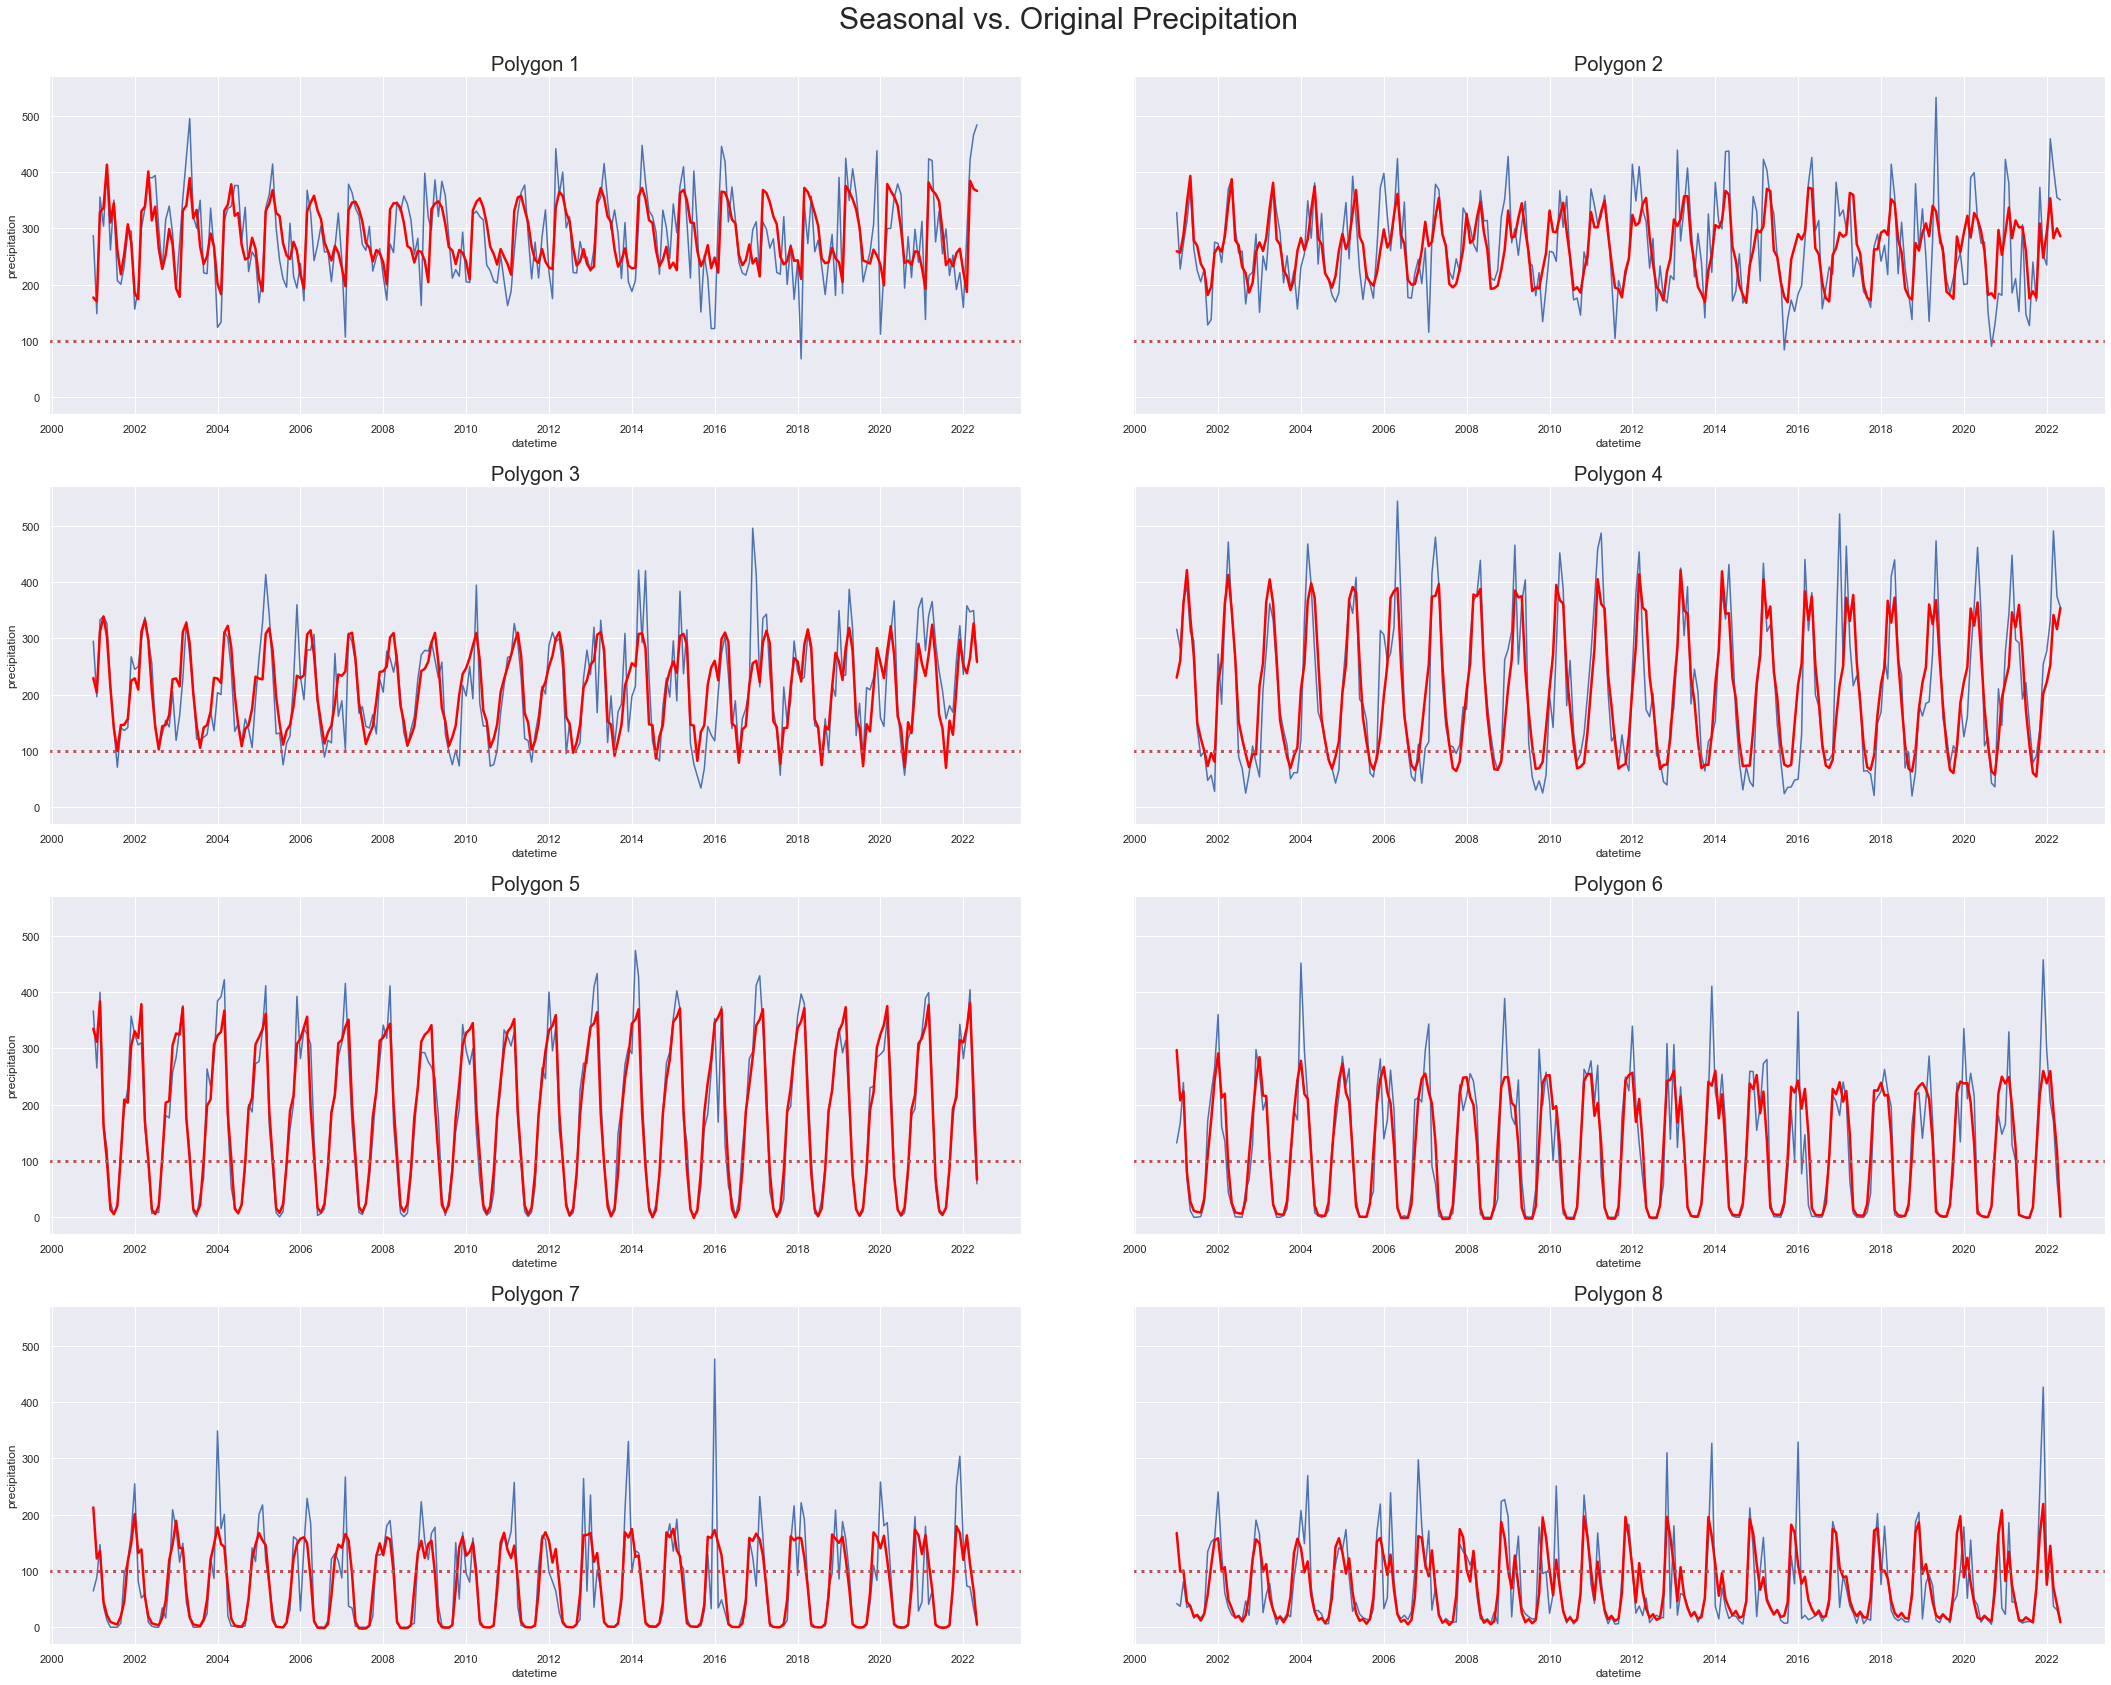

In [66]:
fig, ax = plot.plot_per_polygon(climate, plot_func=lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax), title='Seasonal vs. Original Precipitation', sharey=True)
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax, color='red', linewidth=2.5), title='', fig=fig, ax=ax, sharey=True)
for row in ax:
    for axis in row:
        axis.axhline(y=100, color = 'r', linestyle = 'dotted', linewidth=3)
        locator = mdates.AutoDateLocator(minticks=10, maxticks=17)
        axis.xaxis.set_major_locator(locator) 
        axis.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

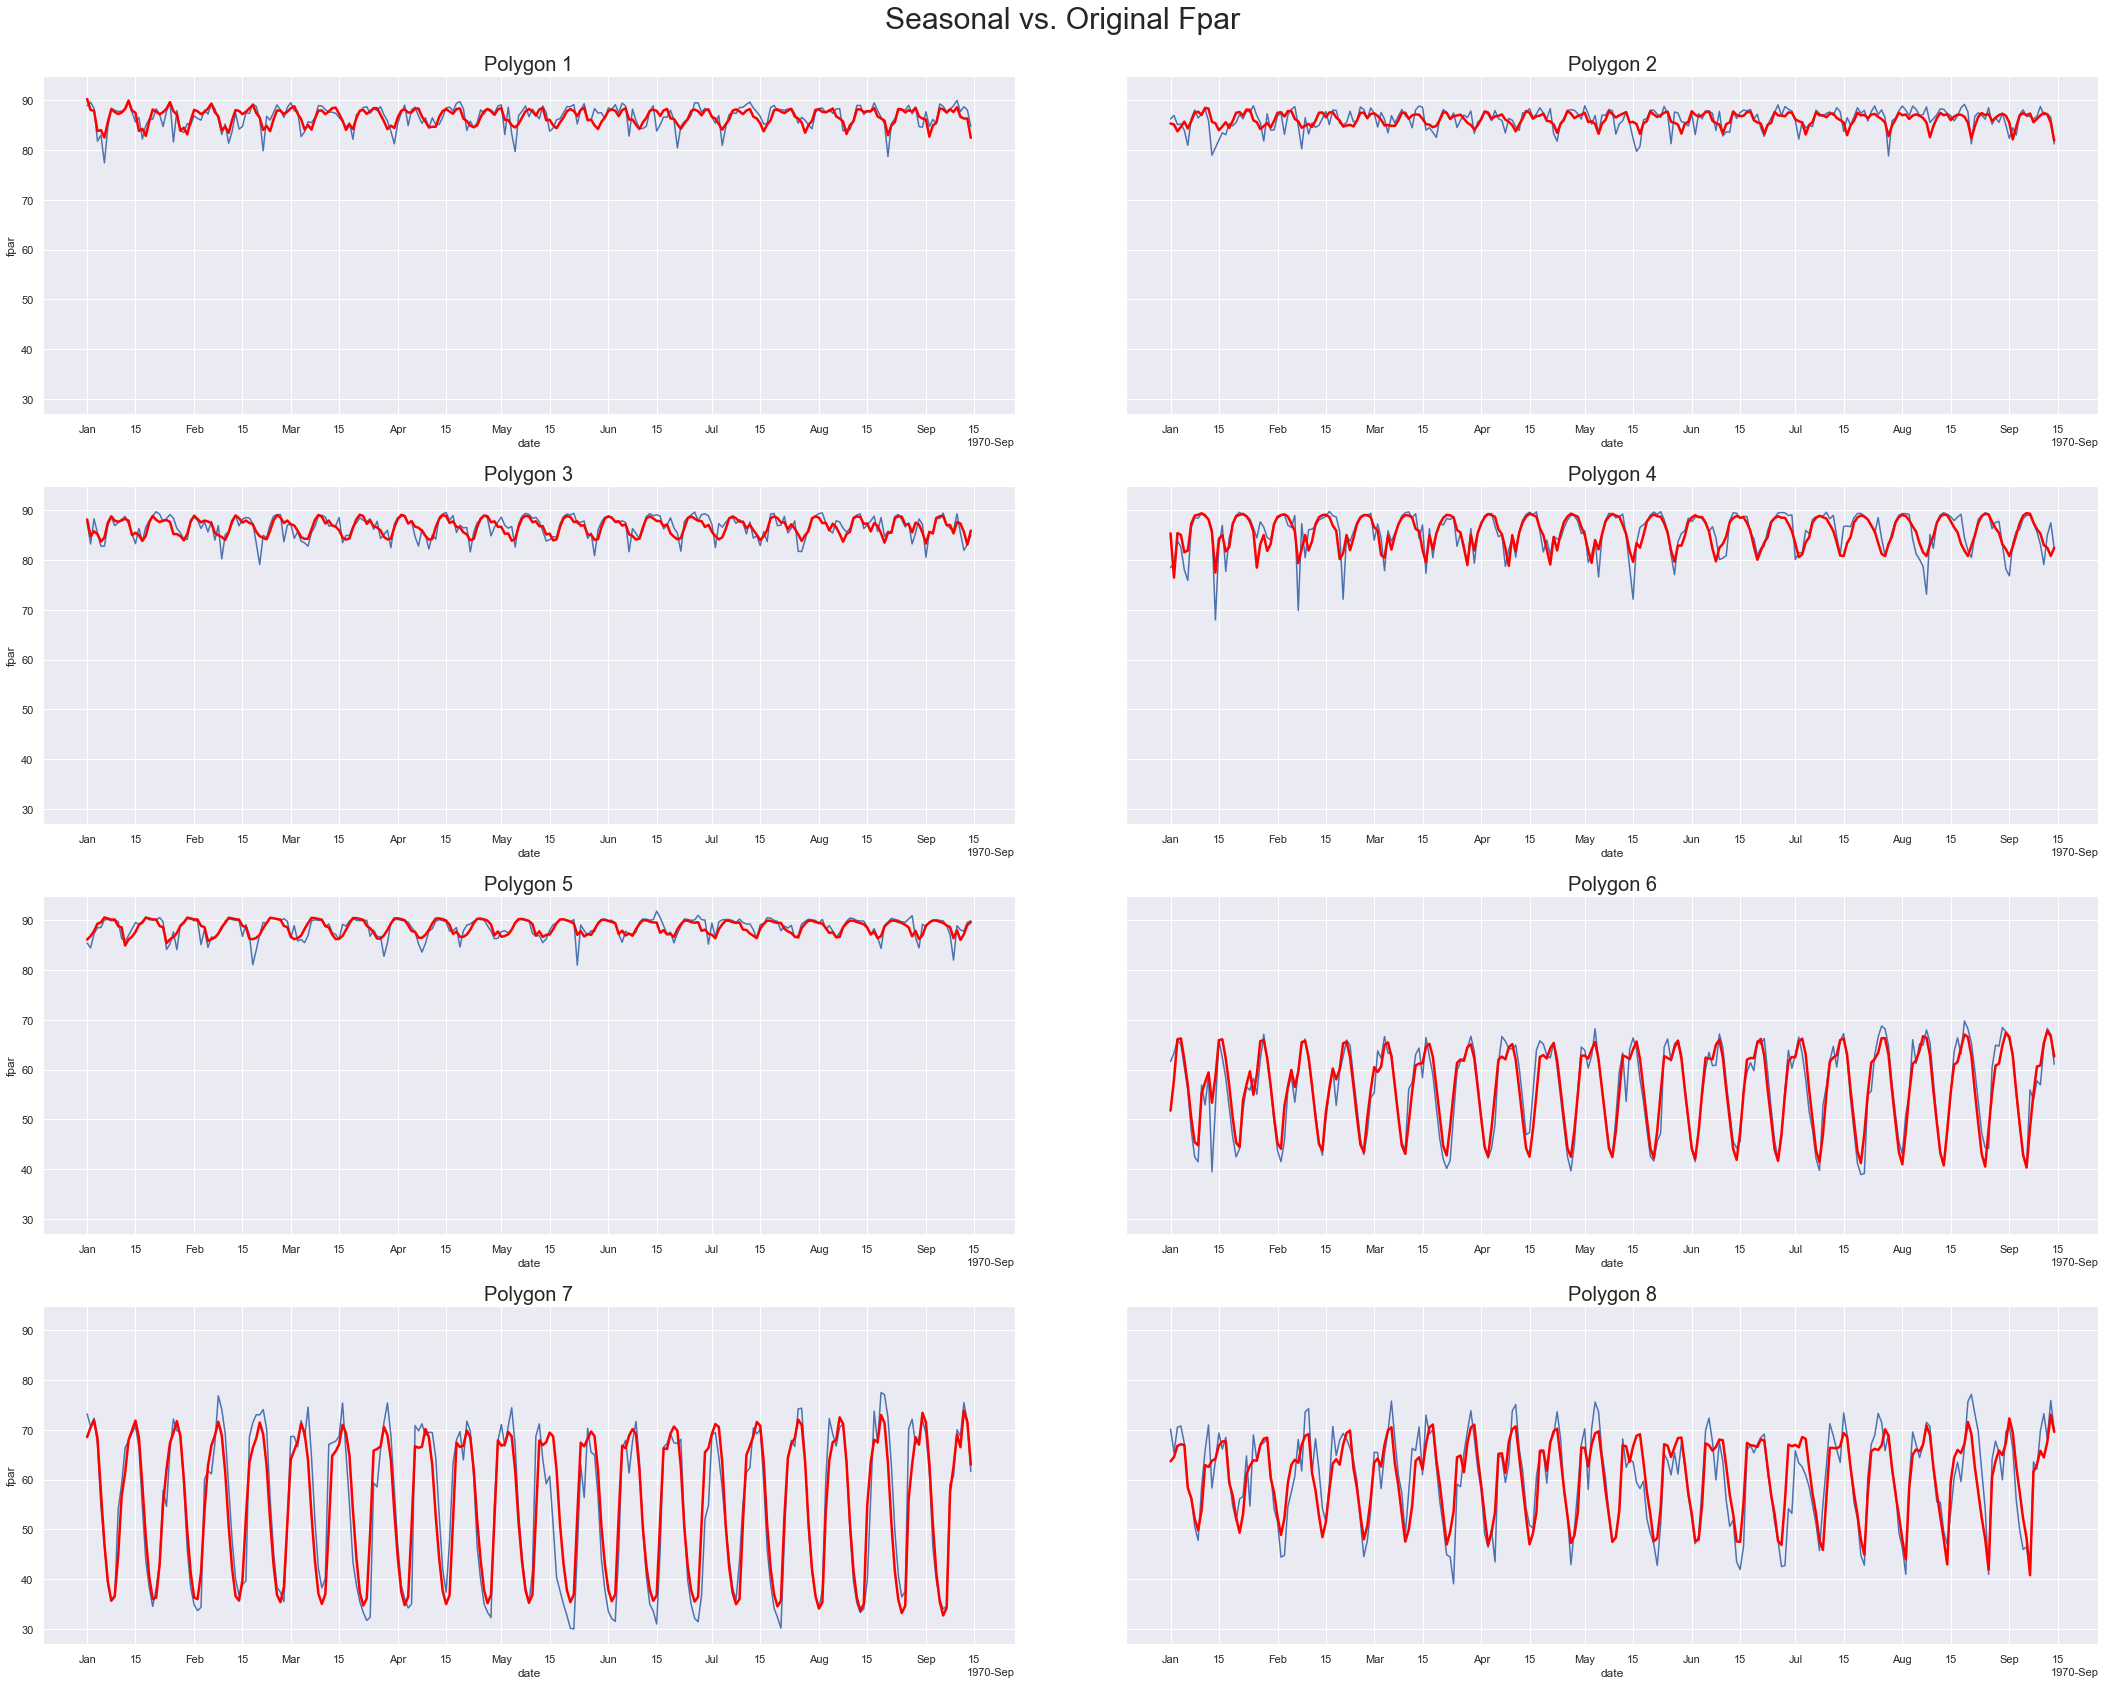

In [67]:
fig, ax = plot.plot_per_polygon(climate, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='fpar', ax=ax), title='Seasonal vs. Original Fpar', sharey=True)
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='fpar', ax=ax, color='red', linewidth=2.5), title='', fig=fig, ax=ax, sharey=True)
format_date(ax)

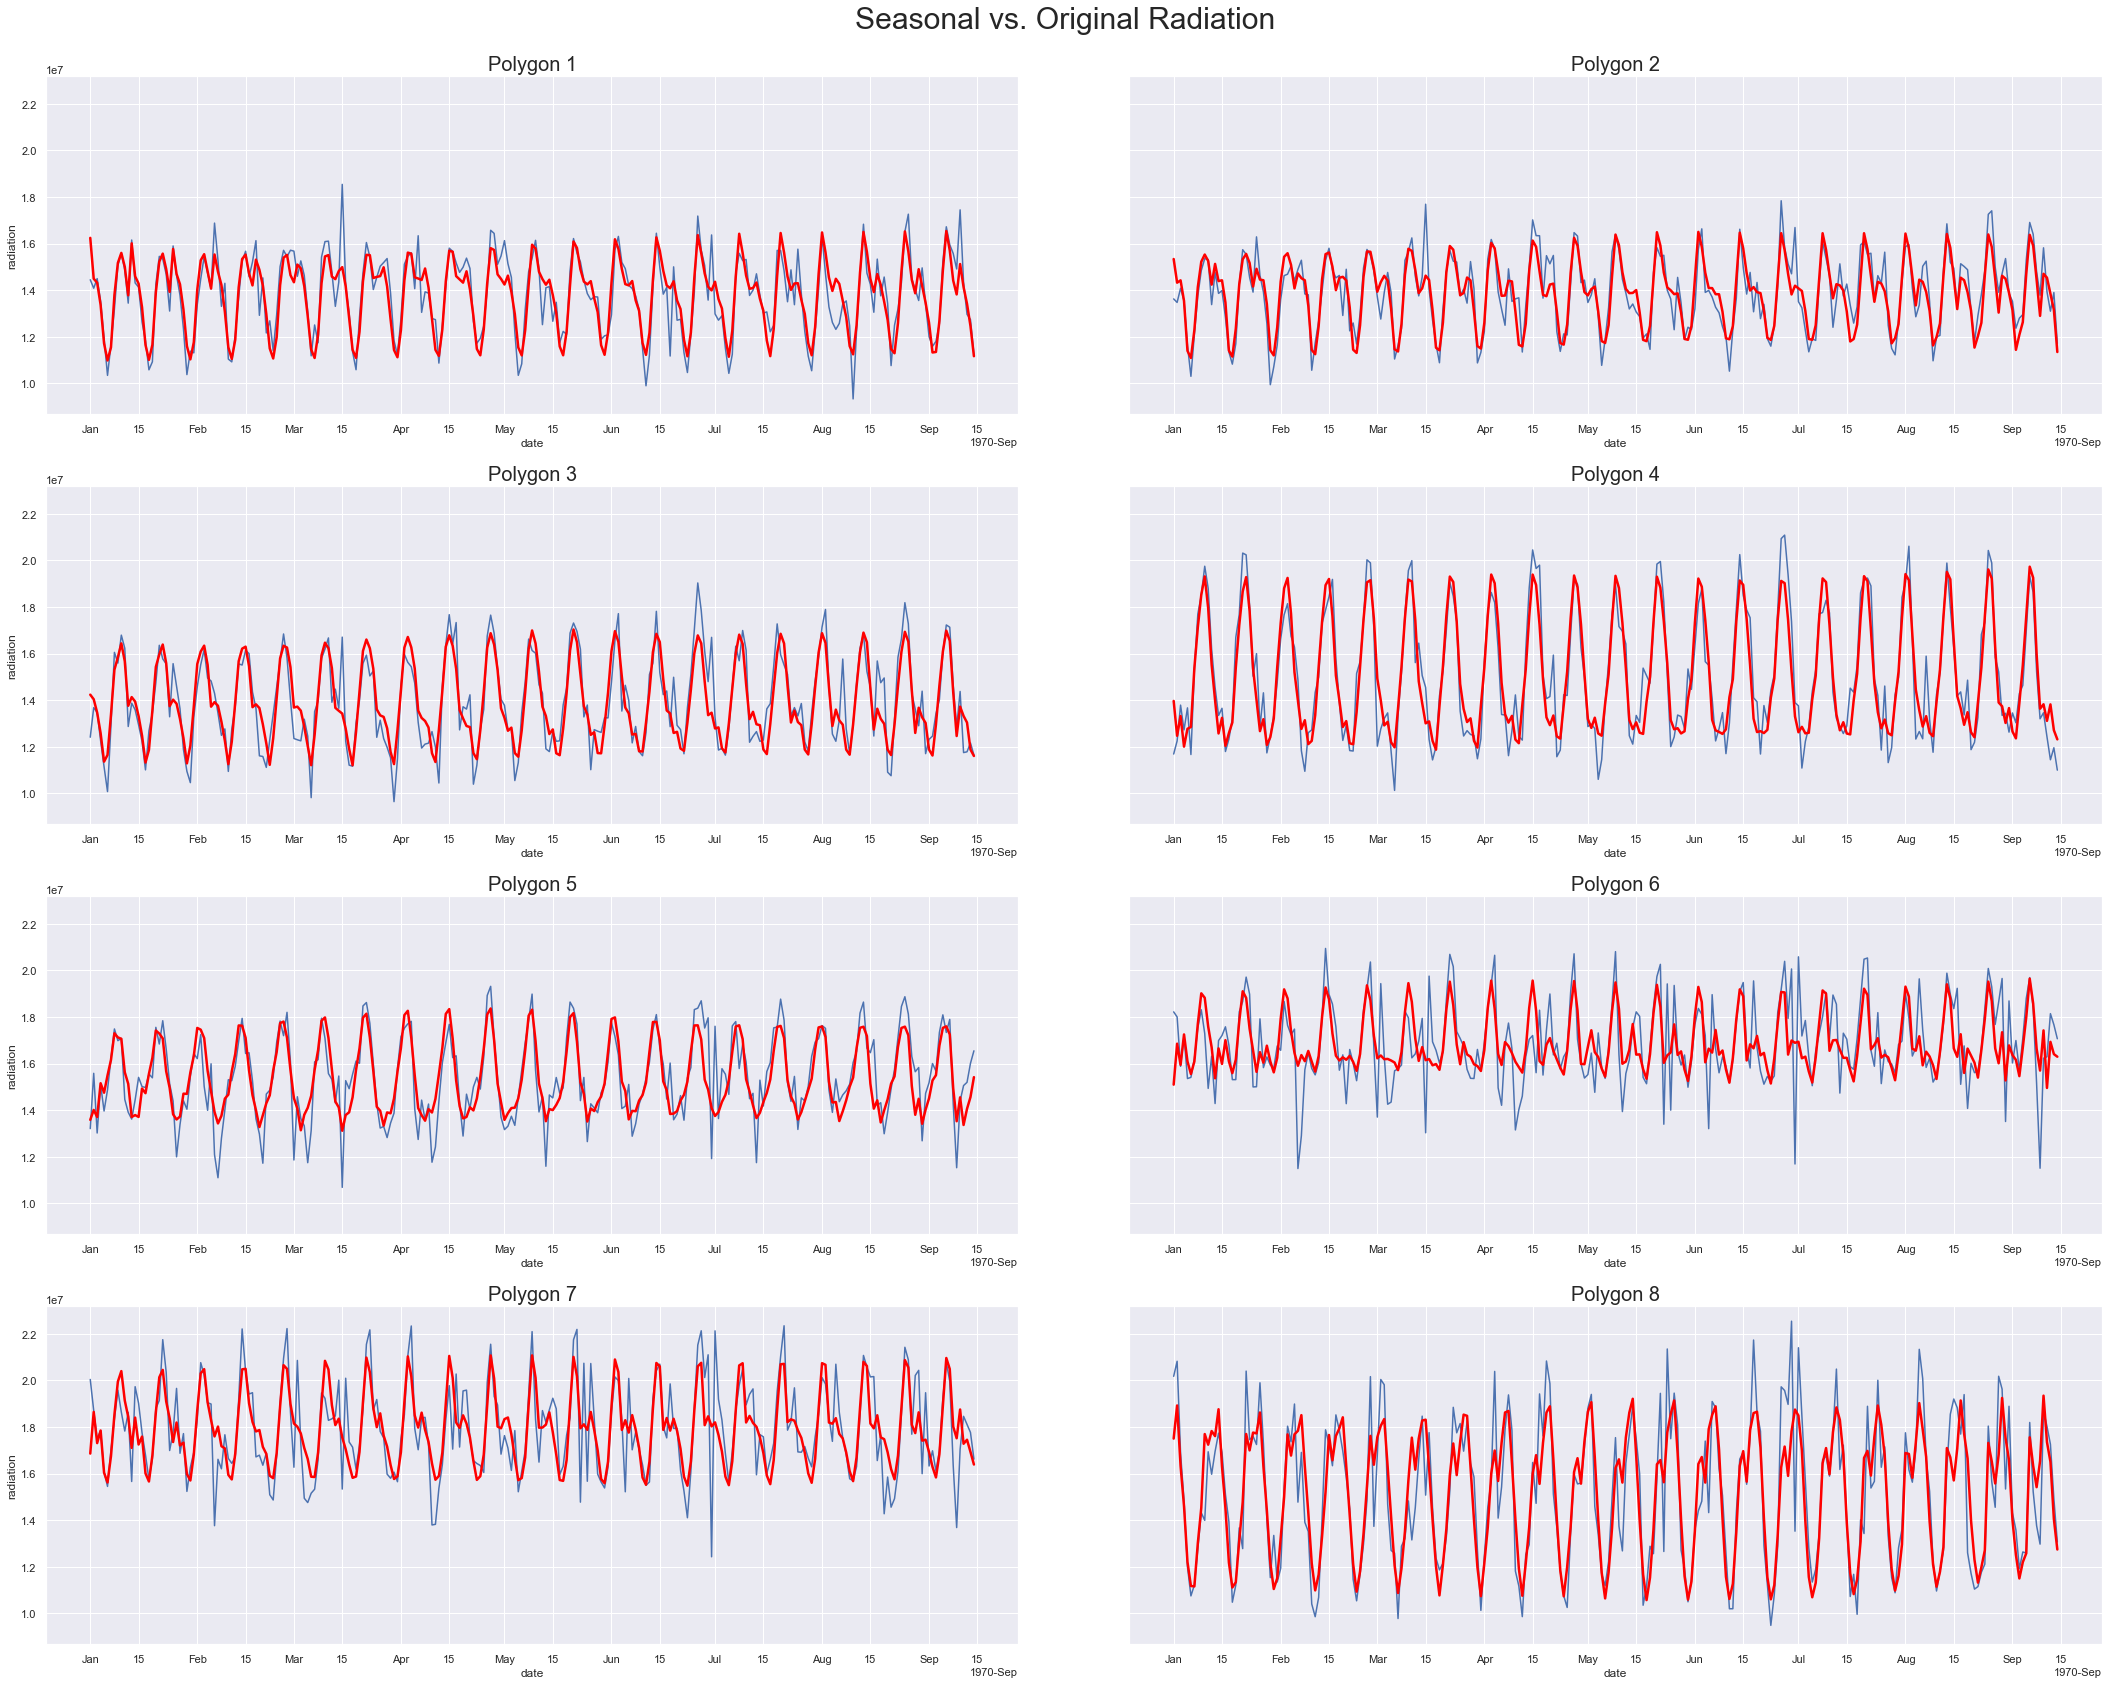

In [68]:
fig, ax = plot.plot_per_polygon(climate, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='radiation', ax=ax), title='Seasonal vs. Original Radiation', sharey=True)
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='radiation', ax=ax, color='red', linewidth=2.5), title='', fig=fig, ax=ax, sharey=True)
format_date(ax)

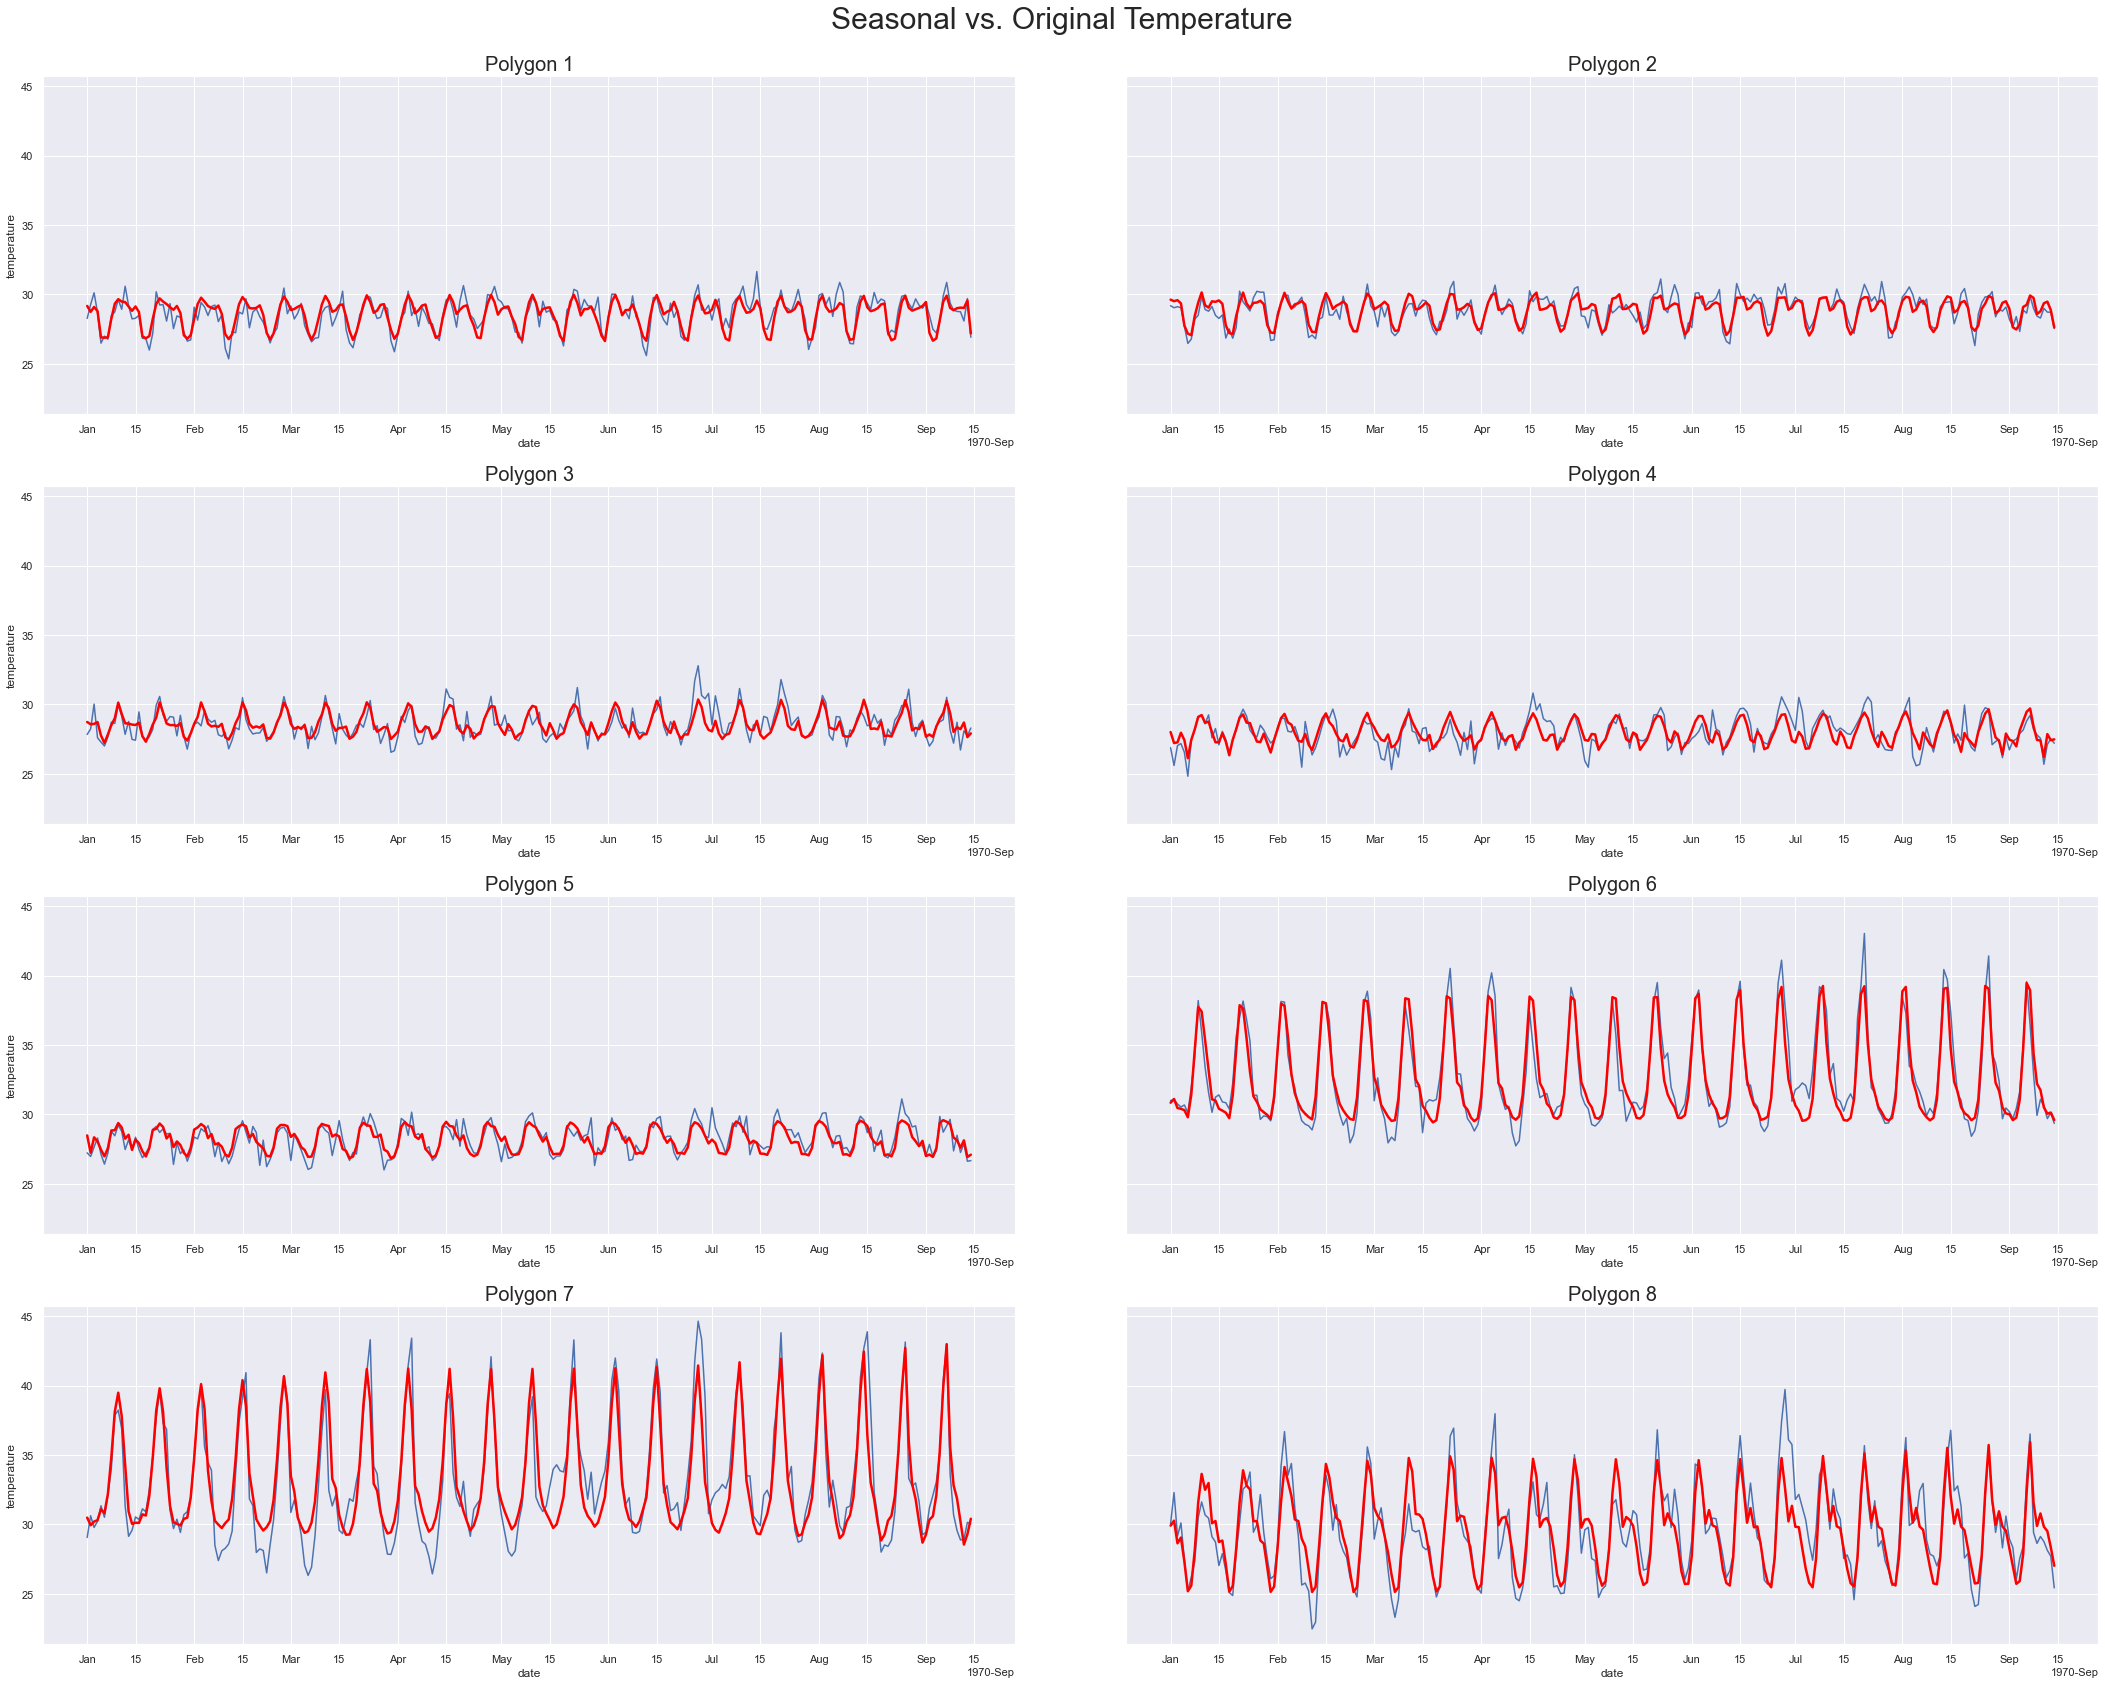

In [69]:
fig, ax = plot.plot_per_polygon(climate, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='temperature', ax=ax), title='Seasonal vs. Original Temperature', sharey=True)
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='temperature', ax=ax, color='red', linewidth=2.5), title='', fig=fig, ax=ax, sharey=True)
format_date(ax)

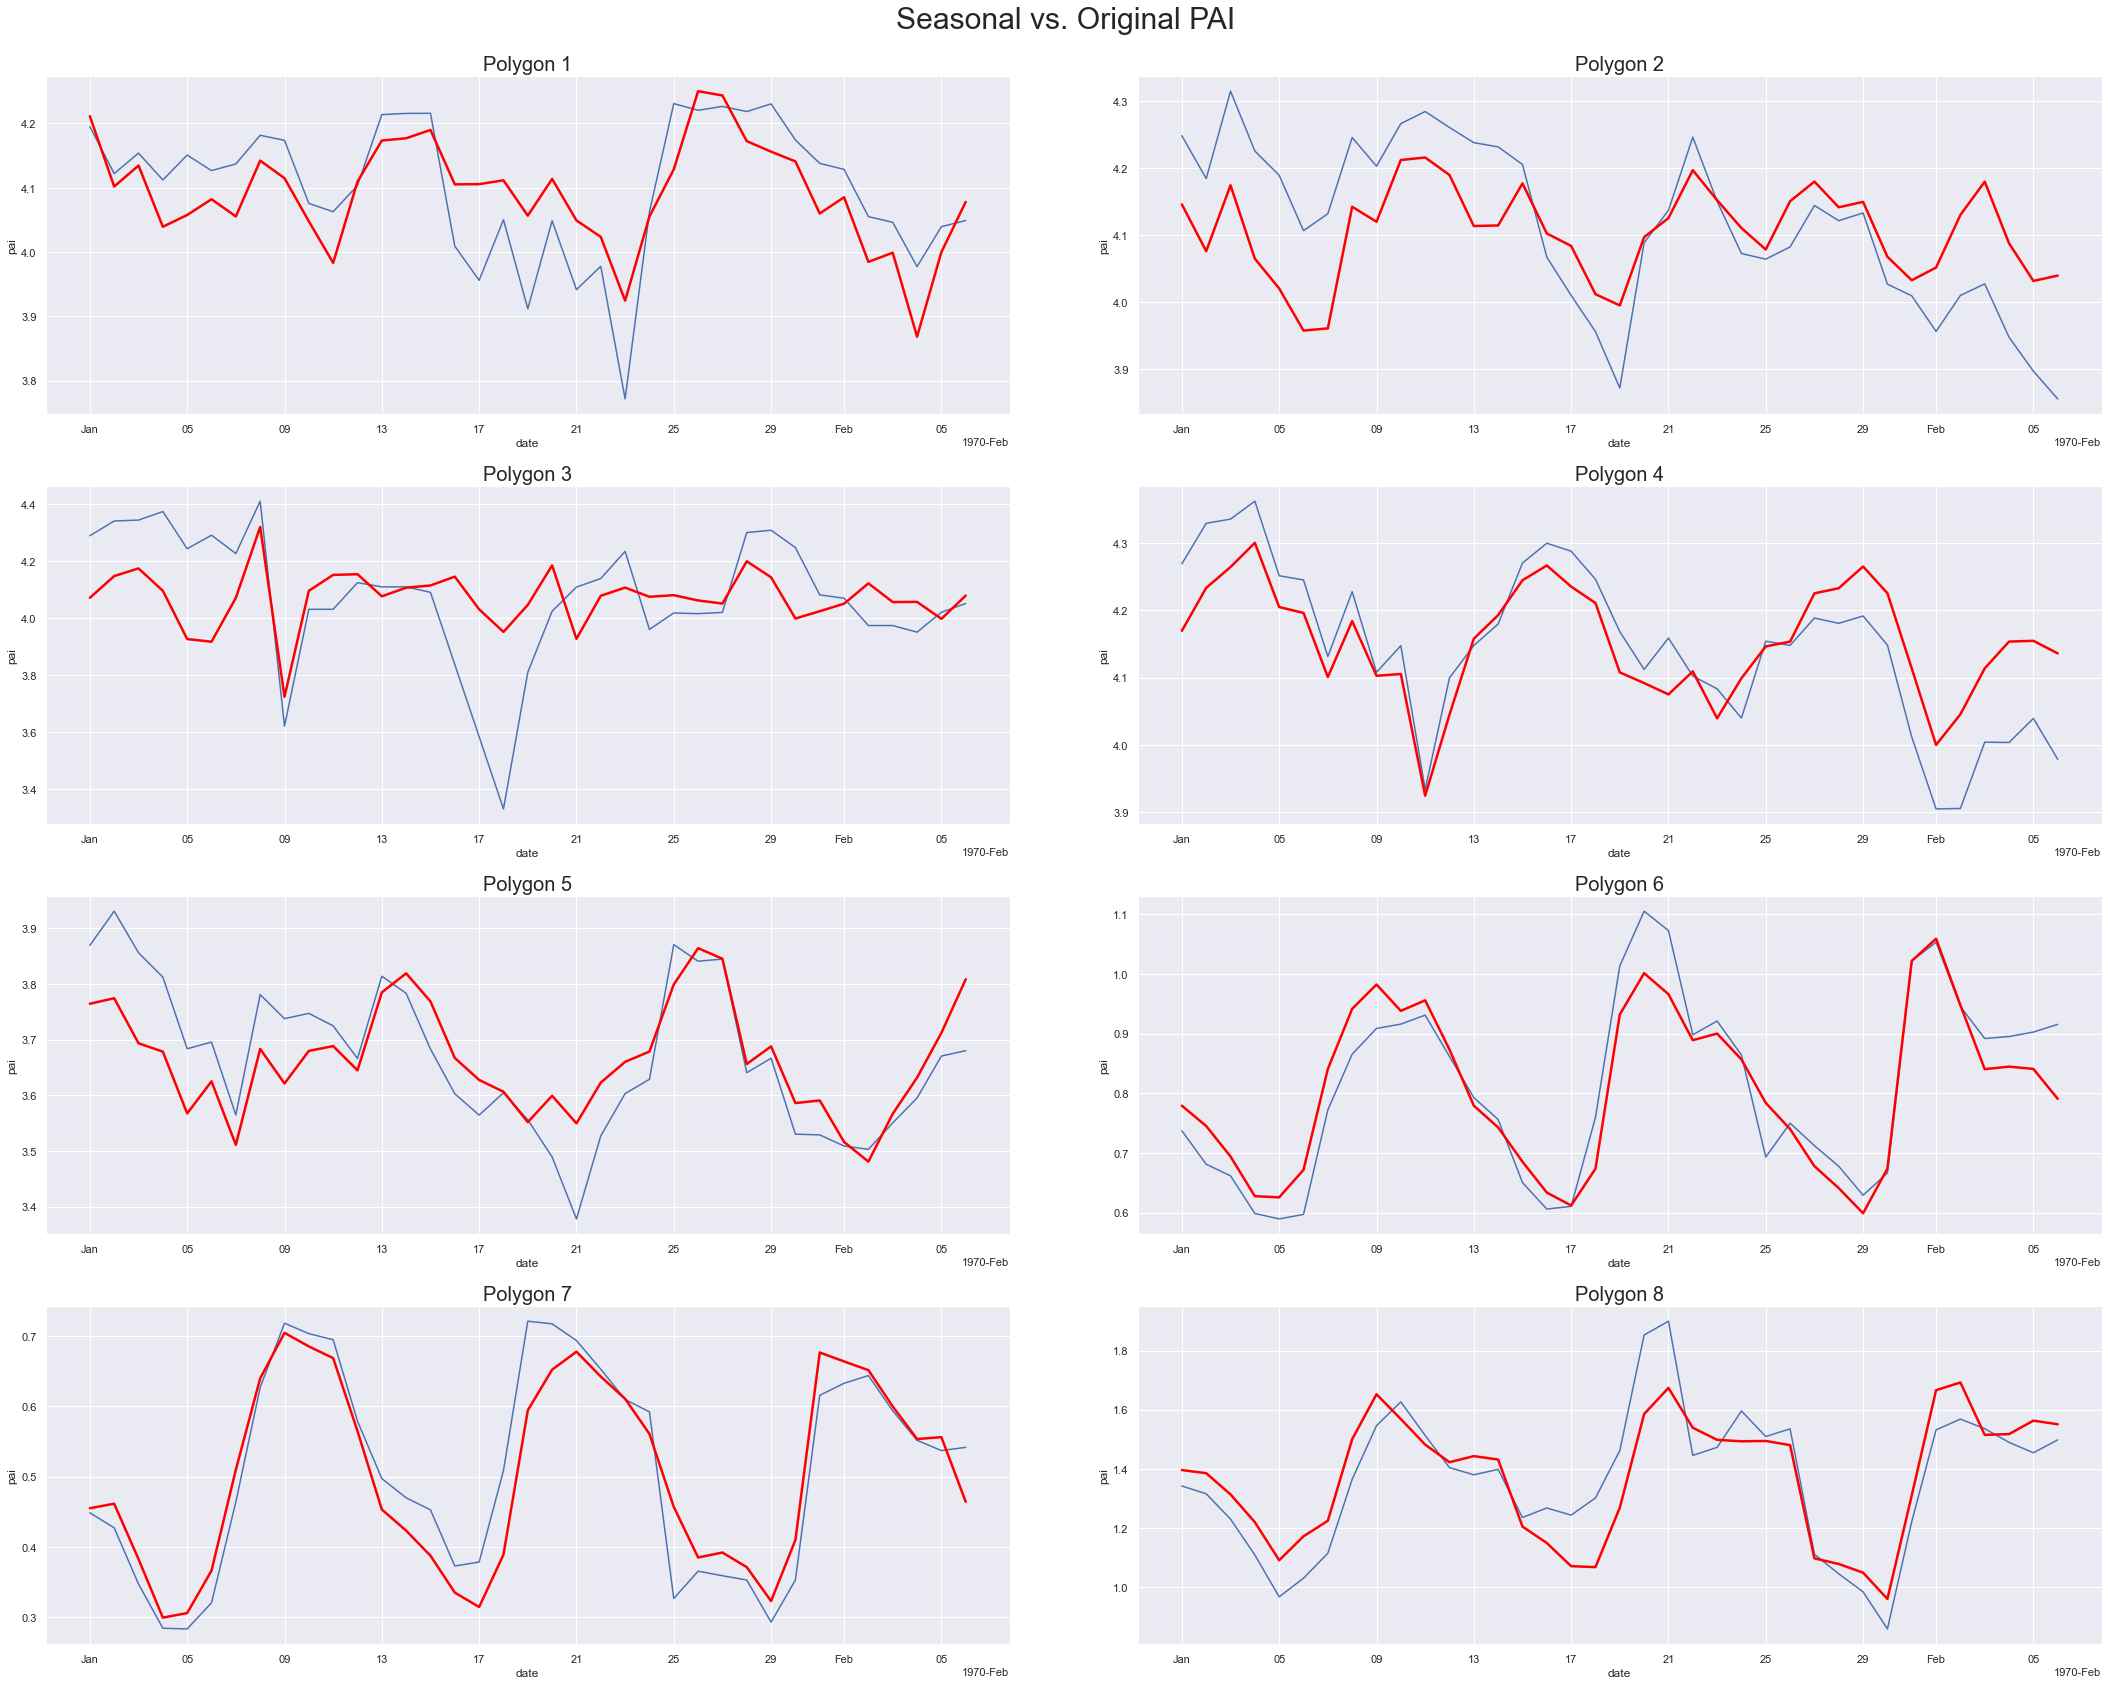

In [70]:
fig, ax = plot.plot_per_polygon(gedi, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='pai', ax=ax), title='Seasonal vs. Original PAI')
fig, ax = plot.plot_per_polygon(gedi_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='date', y='pai', ax=ax, color='red', linewidth=2.5), title='', fig=fig, ax=ax)

format_date(ax)

### Plot climate vs. pai waveforms for each polygon (except 3, because that one sucks)

<AxesSubplot: xlabel='date', ylabel='fpar'>

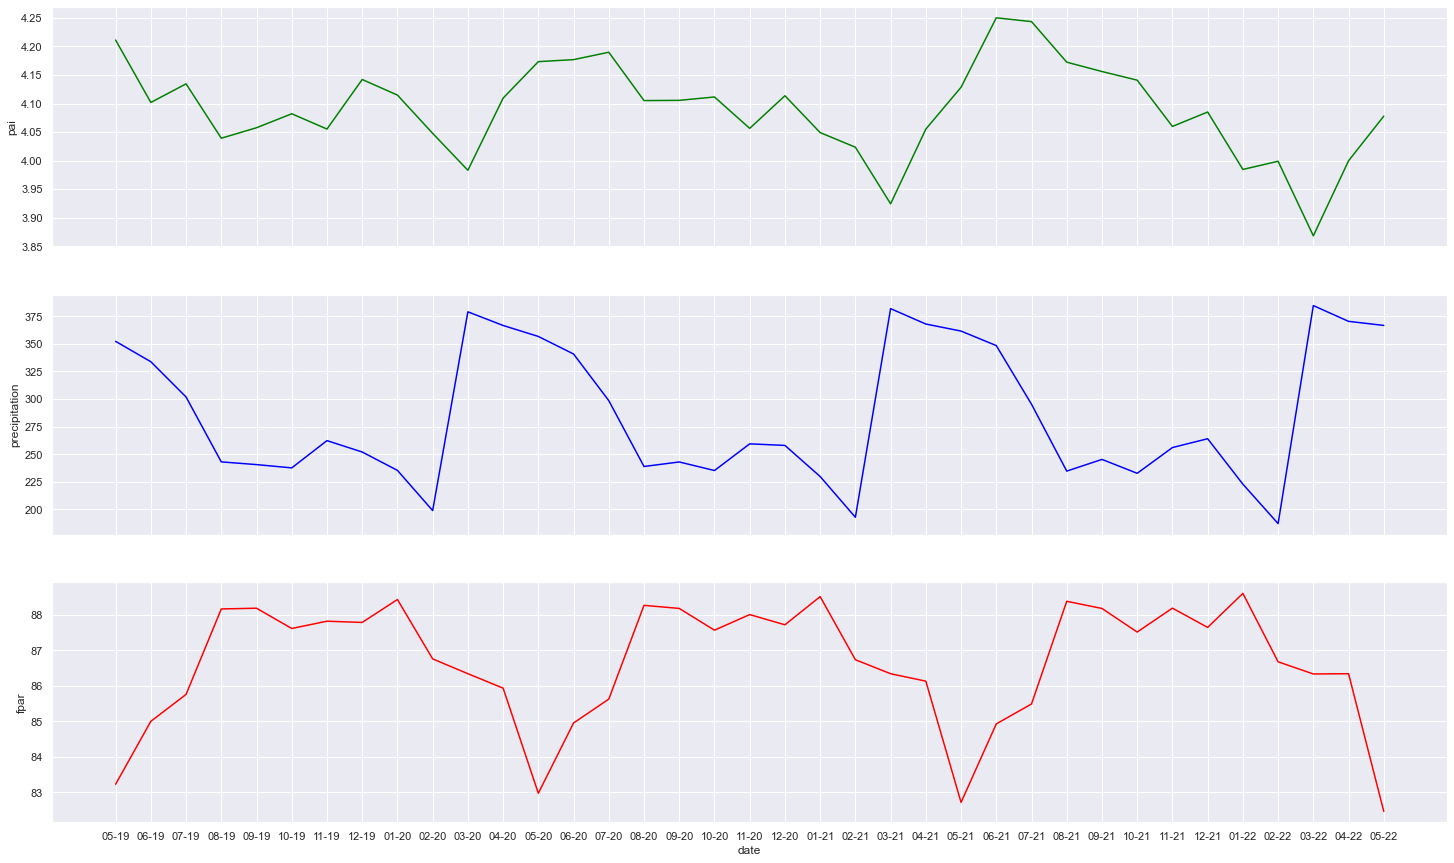

In [72]:
# Polygon 1.
polygon_id = 1
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)
polygon_climate = climate_seasonal[(climate_seasonal.polygon_id==polygon_id) & (climate_seasonal.datetime >= gedi_start_date)]
polygon_gedi = gedi_seasonal[gedi_seasonal.polygon_id==polygon_id]

# Plot
sns.lineplot(polygon_gedi, x='date', y='pai', color='green', ax=ax[0])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='precipitation', color='blue', ax=ax[1])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='fpar', color='red', ax=ax[2])


<AxesSubplot: xlabel='date', ylabel='fpar'>

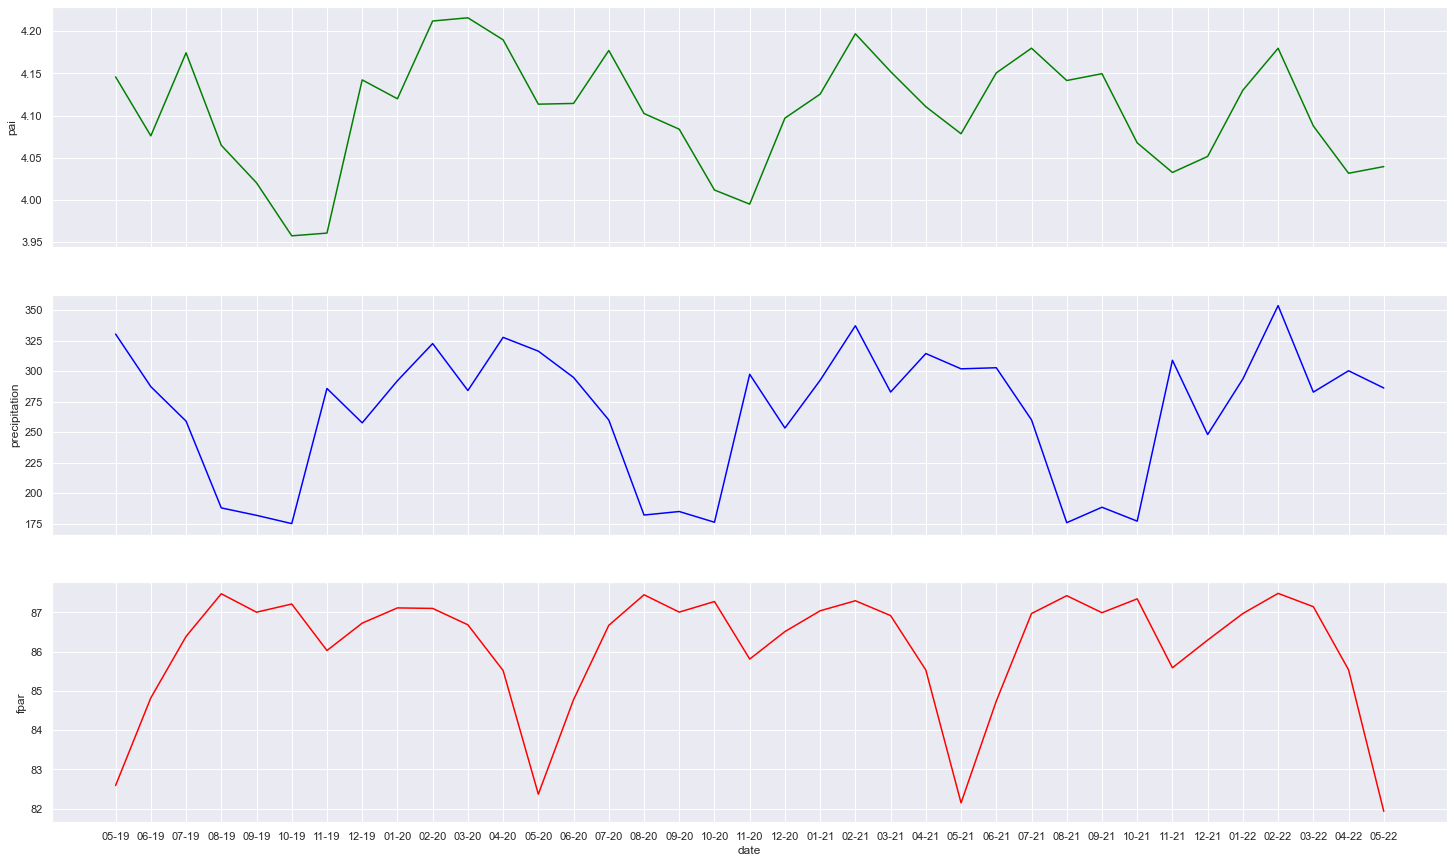

In [73]:
# Polygon 2.
polygon_id = 2
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)
polygon_climate = climate_seasonal[(climate_seasonal.polygon_id==polygon_id) & (climate_seasonal.datetime >= gedi_start_date)]
polygon_gedi = gedi_seasonal[gedi_seasonal.polygon_id==polygon_id]

# Plot
sns.lineplot(polygon_gedi, x='date', y='pai', color='green', ax=ax[0])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='precipitation', color='blue', ax=ax[1])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='fpar', color='red', ax=ax[2])


<AxesSubplot: xlabel='date', ylabel='fpar'>

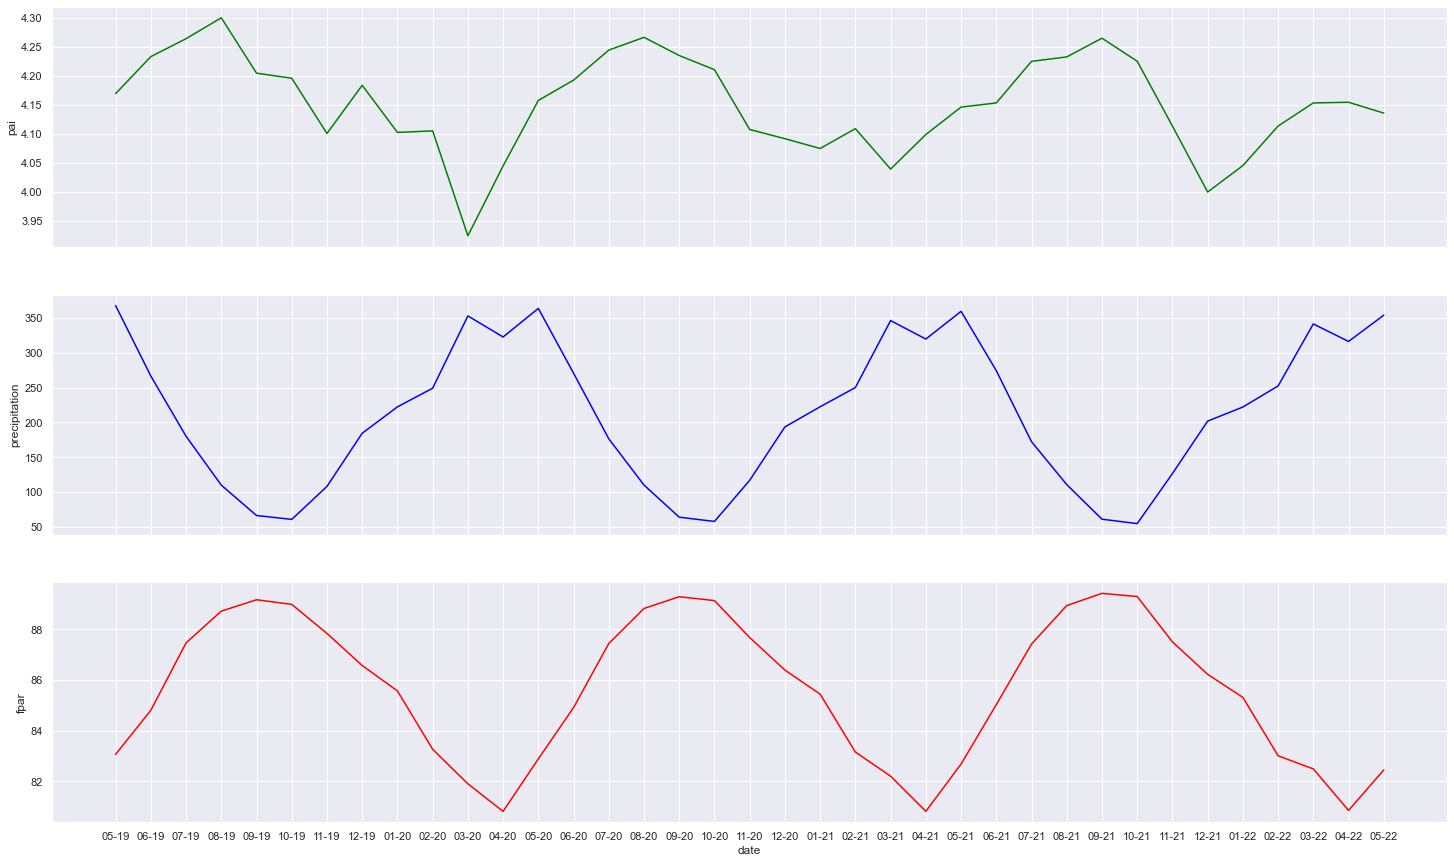

In [74]:
# Polygon 4.
polygon_id = 4
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)
polygon_climate = climate_seasonal[(climate_seasonal.polygon_id==polygon_id) & (climate_seasonal.datetime >= gedi_start_date)]
polygon_gedi = gedi_seasonal[gedi_seasonal.polygon_id==polygon_id]

# Plot
sns.lineplot(polygon_gedi, x='date', y='pai', color='green', ax=ax[0])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='precipitation', color='blue', ax=ax[1])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='fpar', color='red', ax=ax[2])


<AxesSubplot: xlabel='date', ylabel='fpar'>

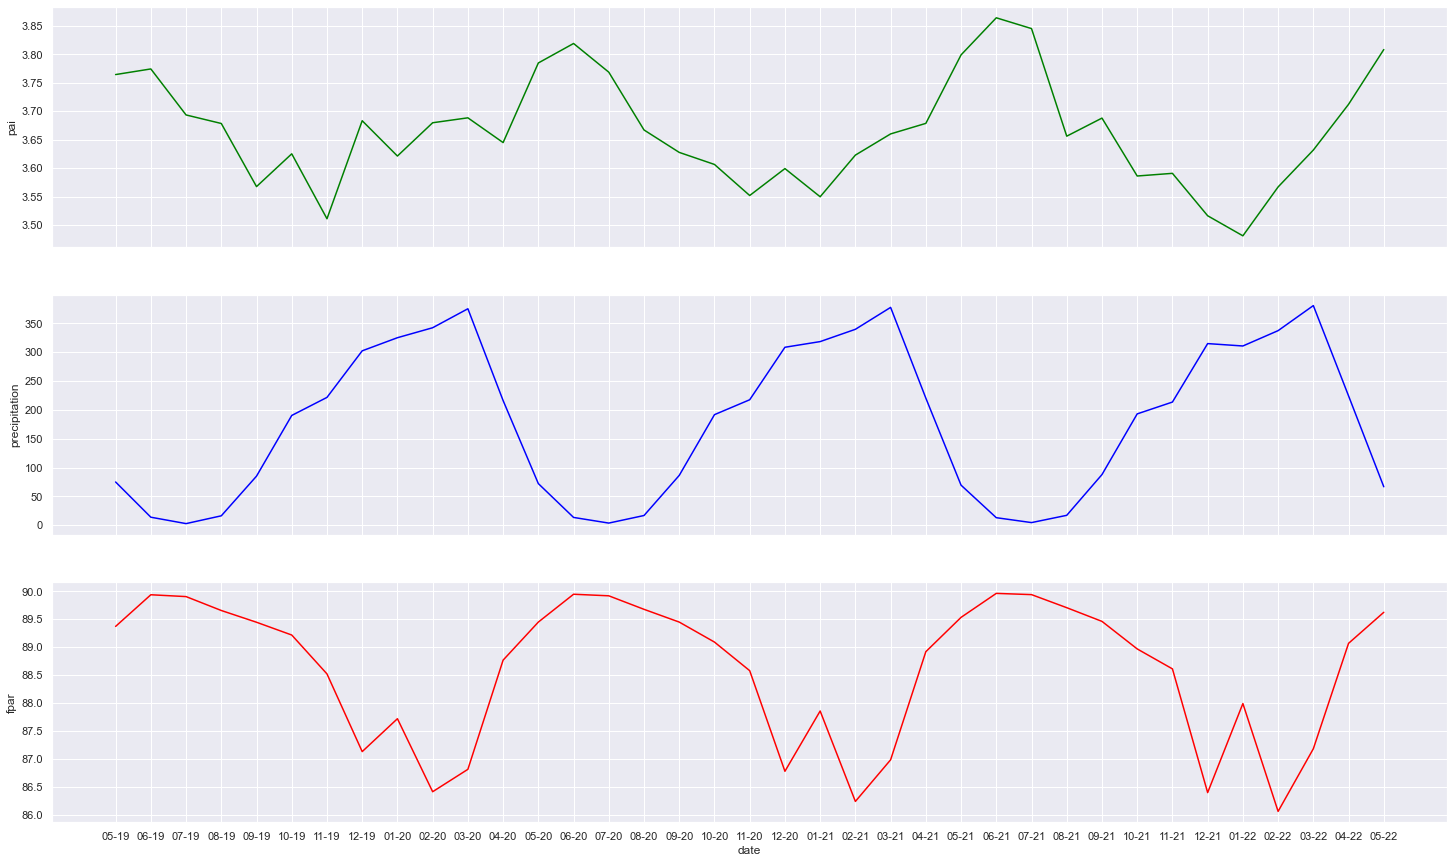

In [75]:
# Polygon 5.
polygon_id = 5
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)
polygon_climate = climate_seasonal[(climate_seasonal.polygon_id==polygon_id) & (climate_seasonal.datetime >= gedi_start_date)]
polygon_gedi = gedi_seasonal[gedi_seasonal.polygon_id==polygon_id]

# Plot
sns.lineplot(polygon_gedi, x='date', y='pai', color='green', ax=ax[0])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='precipitation', color='blue', ax=ax[1])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='fpar', color='red', ax=ax[2])


<AxesSubplot: xlabel='date', ylabel='fpar'>

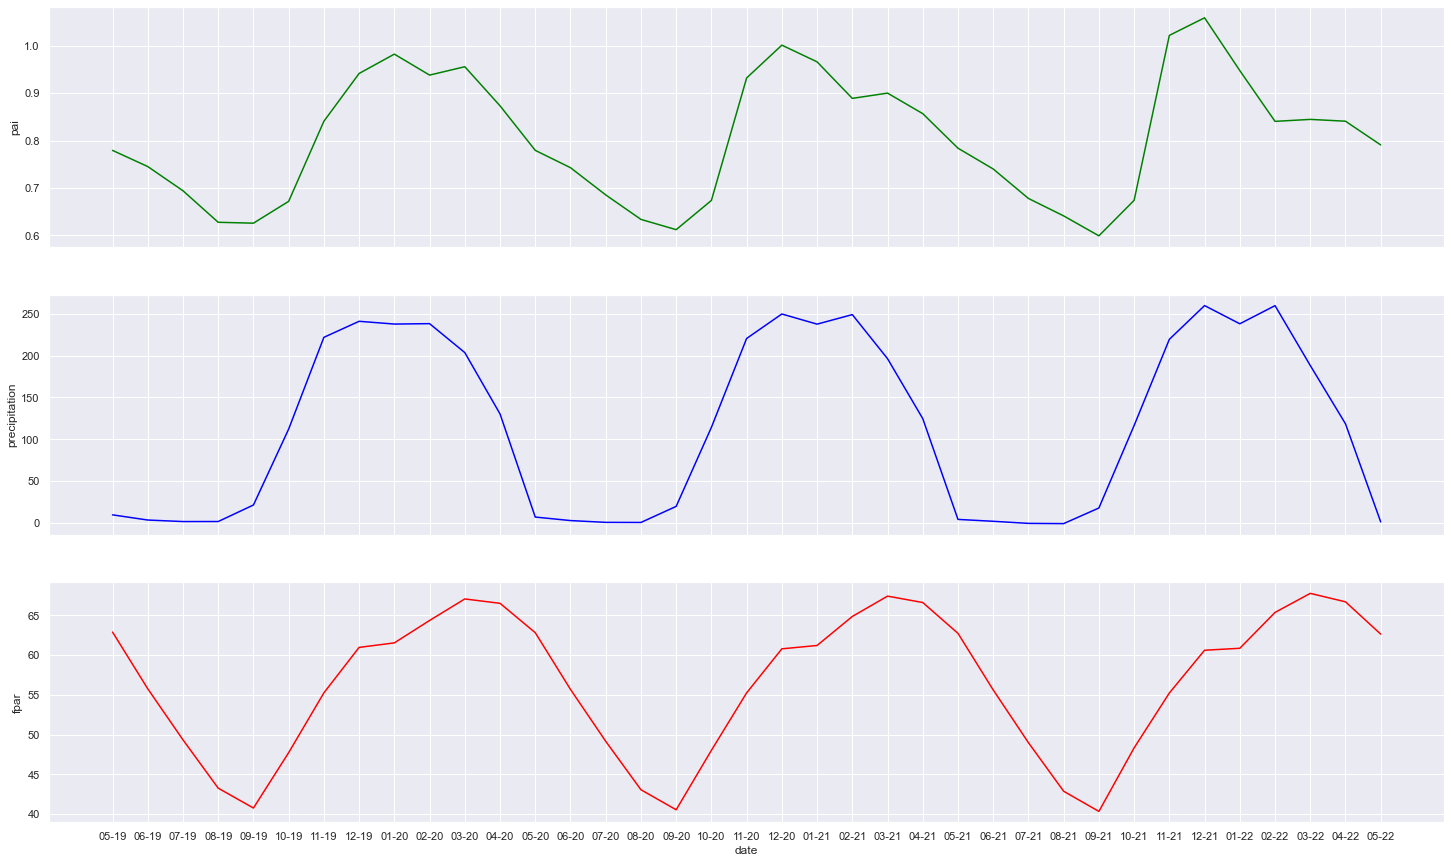

In [76]:
# Polygon 6.
polygon_id = 6
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)
polygon_climate = climate_seasonal[(climate_seasonal.polygon_id==polygon_id) & (climate_seasonal.datetime >= gedi_start_date)]
polygon_gedi = gedi_seasonal[gedi_seasonal.polygon_id==polygon_id]

# Plot
sns.lineplot(polygon_gedi, x='date', y='pai', color='green', ax=ax[0])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='precipitation', color='blue', ax=ax[1])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='fpar', color='red', ax=ax[2])


<AxesSubplot: xlabel='date', ylabel='fpar'>

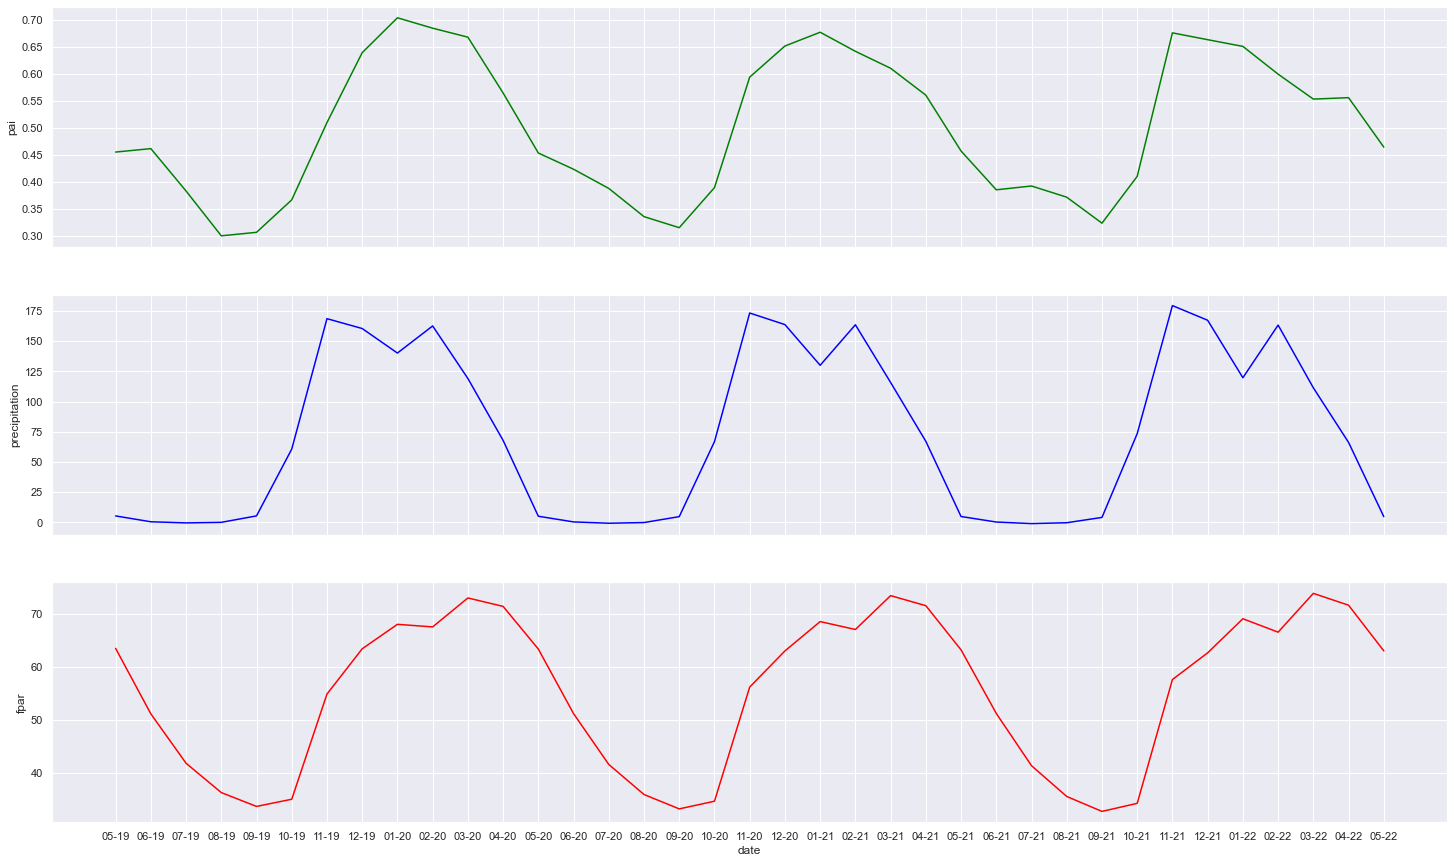

In [77]:
# Polygon 7.
polygon_id = 7
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)
polygon_climate = climate_seasonal[(climate_seasonal.polygon_id==polygon_id) & (climate_seasonal.datetime >= gedi_start_date)]
polygon_gedi = gedi_seasonal[gedi_seasonal.polygon_id==polygon_id]

# Plot
sns.lineplot(polygon_gedi, x='date', y='pai', color='green', ax=ax[0])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='precipitation', color='blue', ax=ax[1])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='fpar', color='red', ax=ax[2])


<AxesSubplot: xlabel='date', ylabel='fpar'>

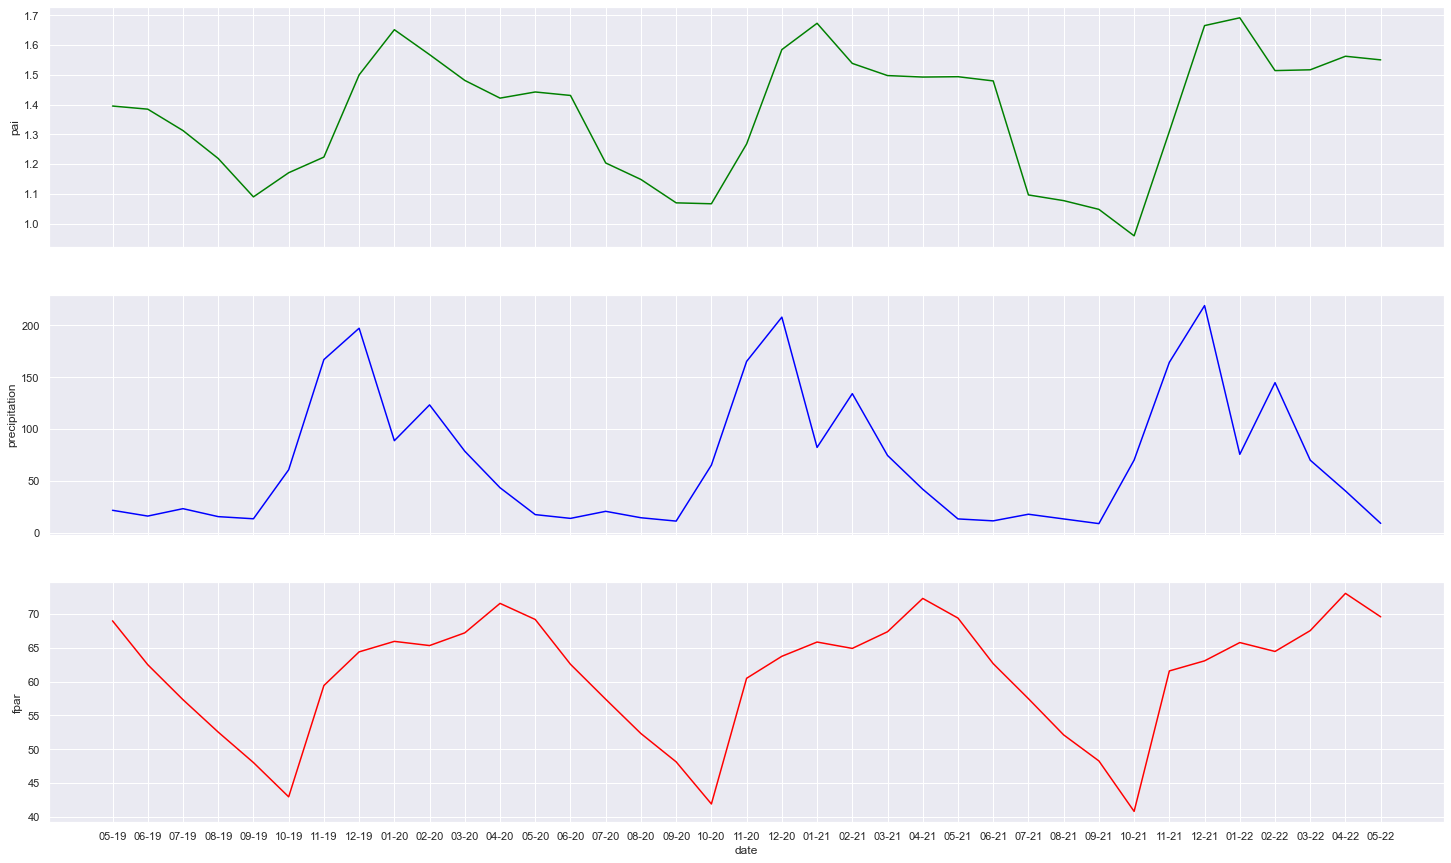

In [78]:
# Polygon 8.
polygon_id = 8
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)
polygon_climate = climate_seasonal[(climate_seasonal.polygon_id==polygon_id) & (climate_seasonal.datetime >= gedi_start_date)]
polygon_gedi = gedi_seasonal[gedi_seasonal.polygon_id==polygon_id]

# Plot
sns.lineplot(polygon_gedi, x='date', y='pai', color='green', ax=ax[0])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='precipitation', color='blue', ax=ax[1])
#plt.show()
sns.lineplot(polygon_climate, x='date', y='fpar', color='red', ax=ax[2])


### Plot yearly aggregate waves

### Helper methods for calculating relationship between climate vars and vegetation

In [79]:
def join_and_shift_data(climate_data, gedi_data, polygon_id):
    # Polygon 1.
    columns = ['temperature', 'radiation', 'fpar', 'P-PET', 'precipitation']
    polygon_climate = climate_data[(climate_data.polygon_id==polygon_id) & (climate_data.datetime >= gedi_start_date)]
    polygon_gedi = gedi_data[gedi_data.polygon_id==polygon_id]

    polygon_join = polygon_climate.set_index('date')[[*columns]].join(polygon_gedi.set_index('date')[['pai', 'month']])
    for i in range(-2, 3):
        if i==0:
            continue
        for column in columns:
            polygon_join[f"{column}_{i}"] = polygon_join[column].shift(i)
    return polygon_join

In [80]:
def get_correlations(joined_df):
    correlations = joined_df.corr()
    correlations['pai_abs'] = correlations.pai.abs()
    correlations = correlations.sort_values('pai_abs', ascending=False)
    return correlations['pai']

### Calculate correlations in the original signal

### Calculate correlations between seasonal components

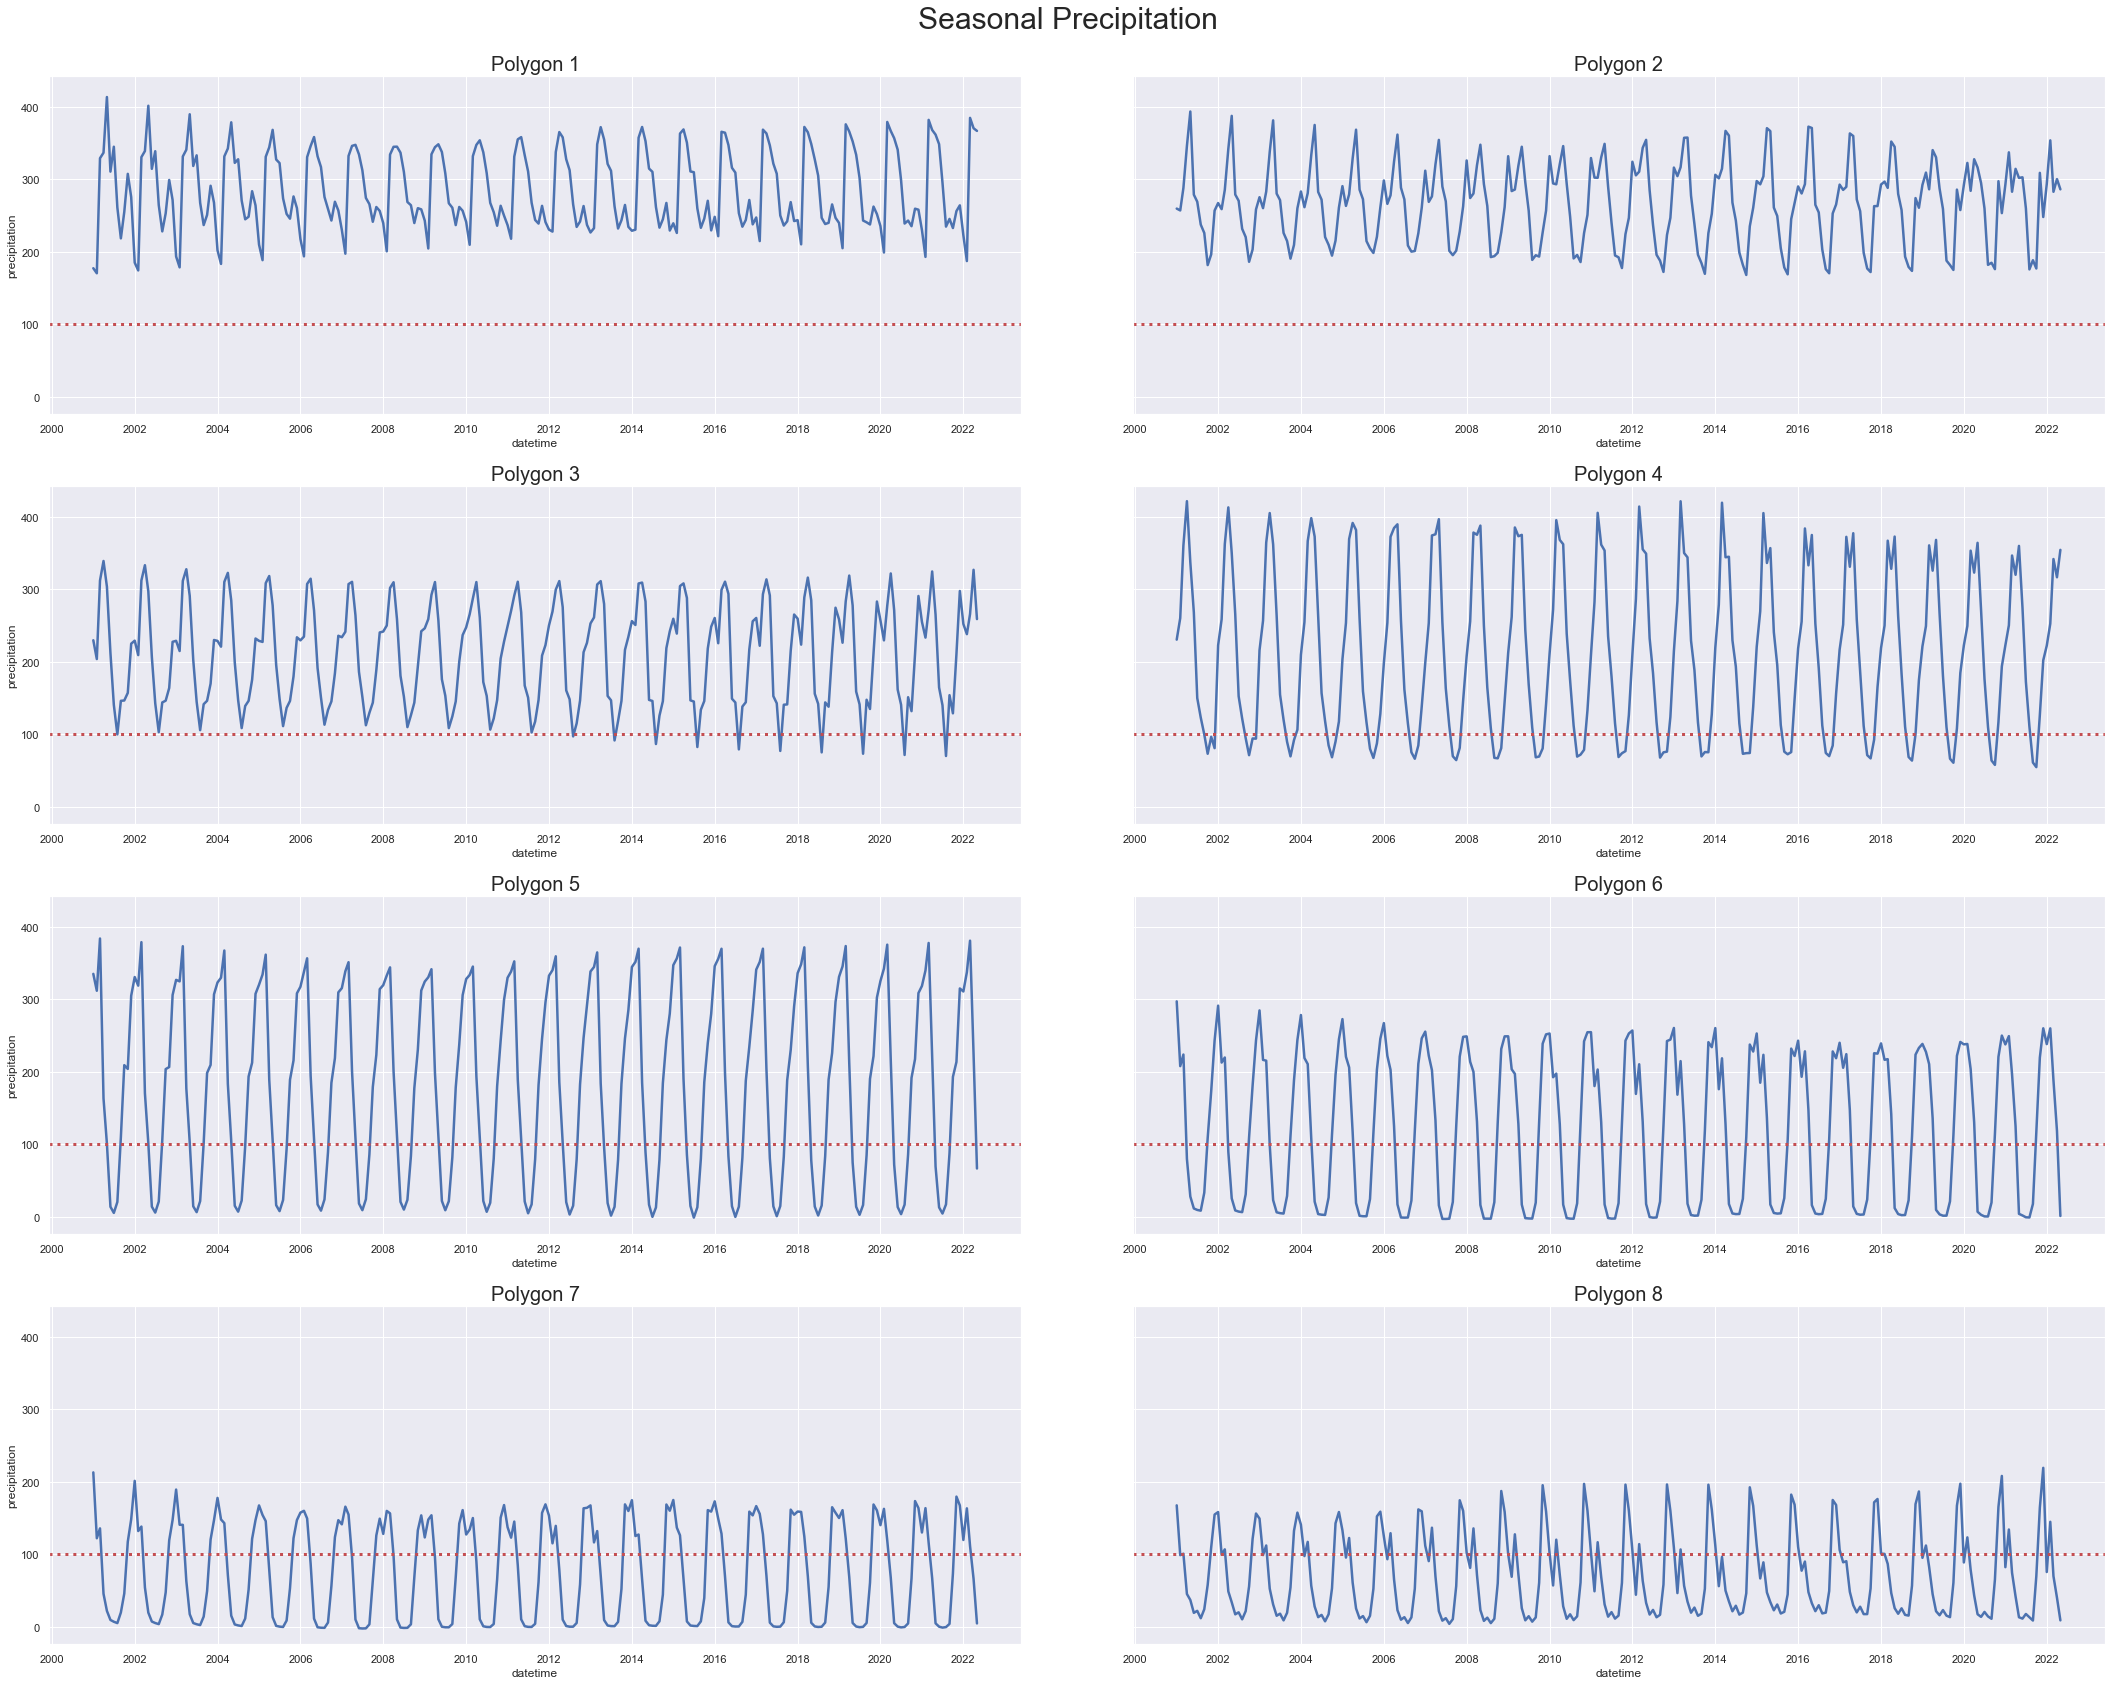

In [84]:
import matplotlib.dates as mdates
sns.set_style({'axes.grid' : True})
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax, linewidth=2.5), title='Seasonal Precipitation', sharey=True)
for lala in ax:
    for bla in lala:
        bla.axhline(y=100, color = 'r', linestyle = 'dotted', linewidth=3)
        locator = mdates.AutoDateLocator(minticks=10, maxticks=17)
        bla.xaxis.set_major_locator(locator) 
        bla.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator)) 

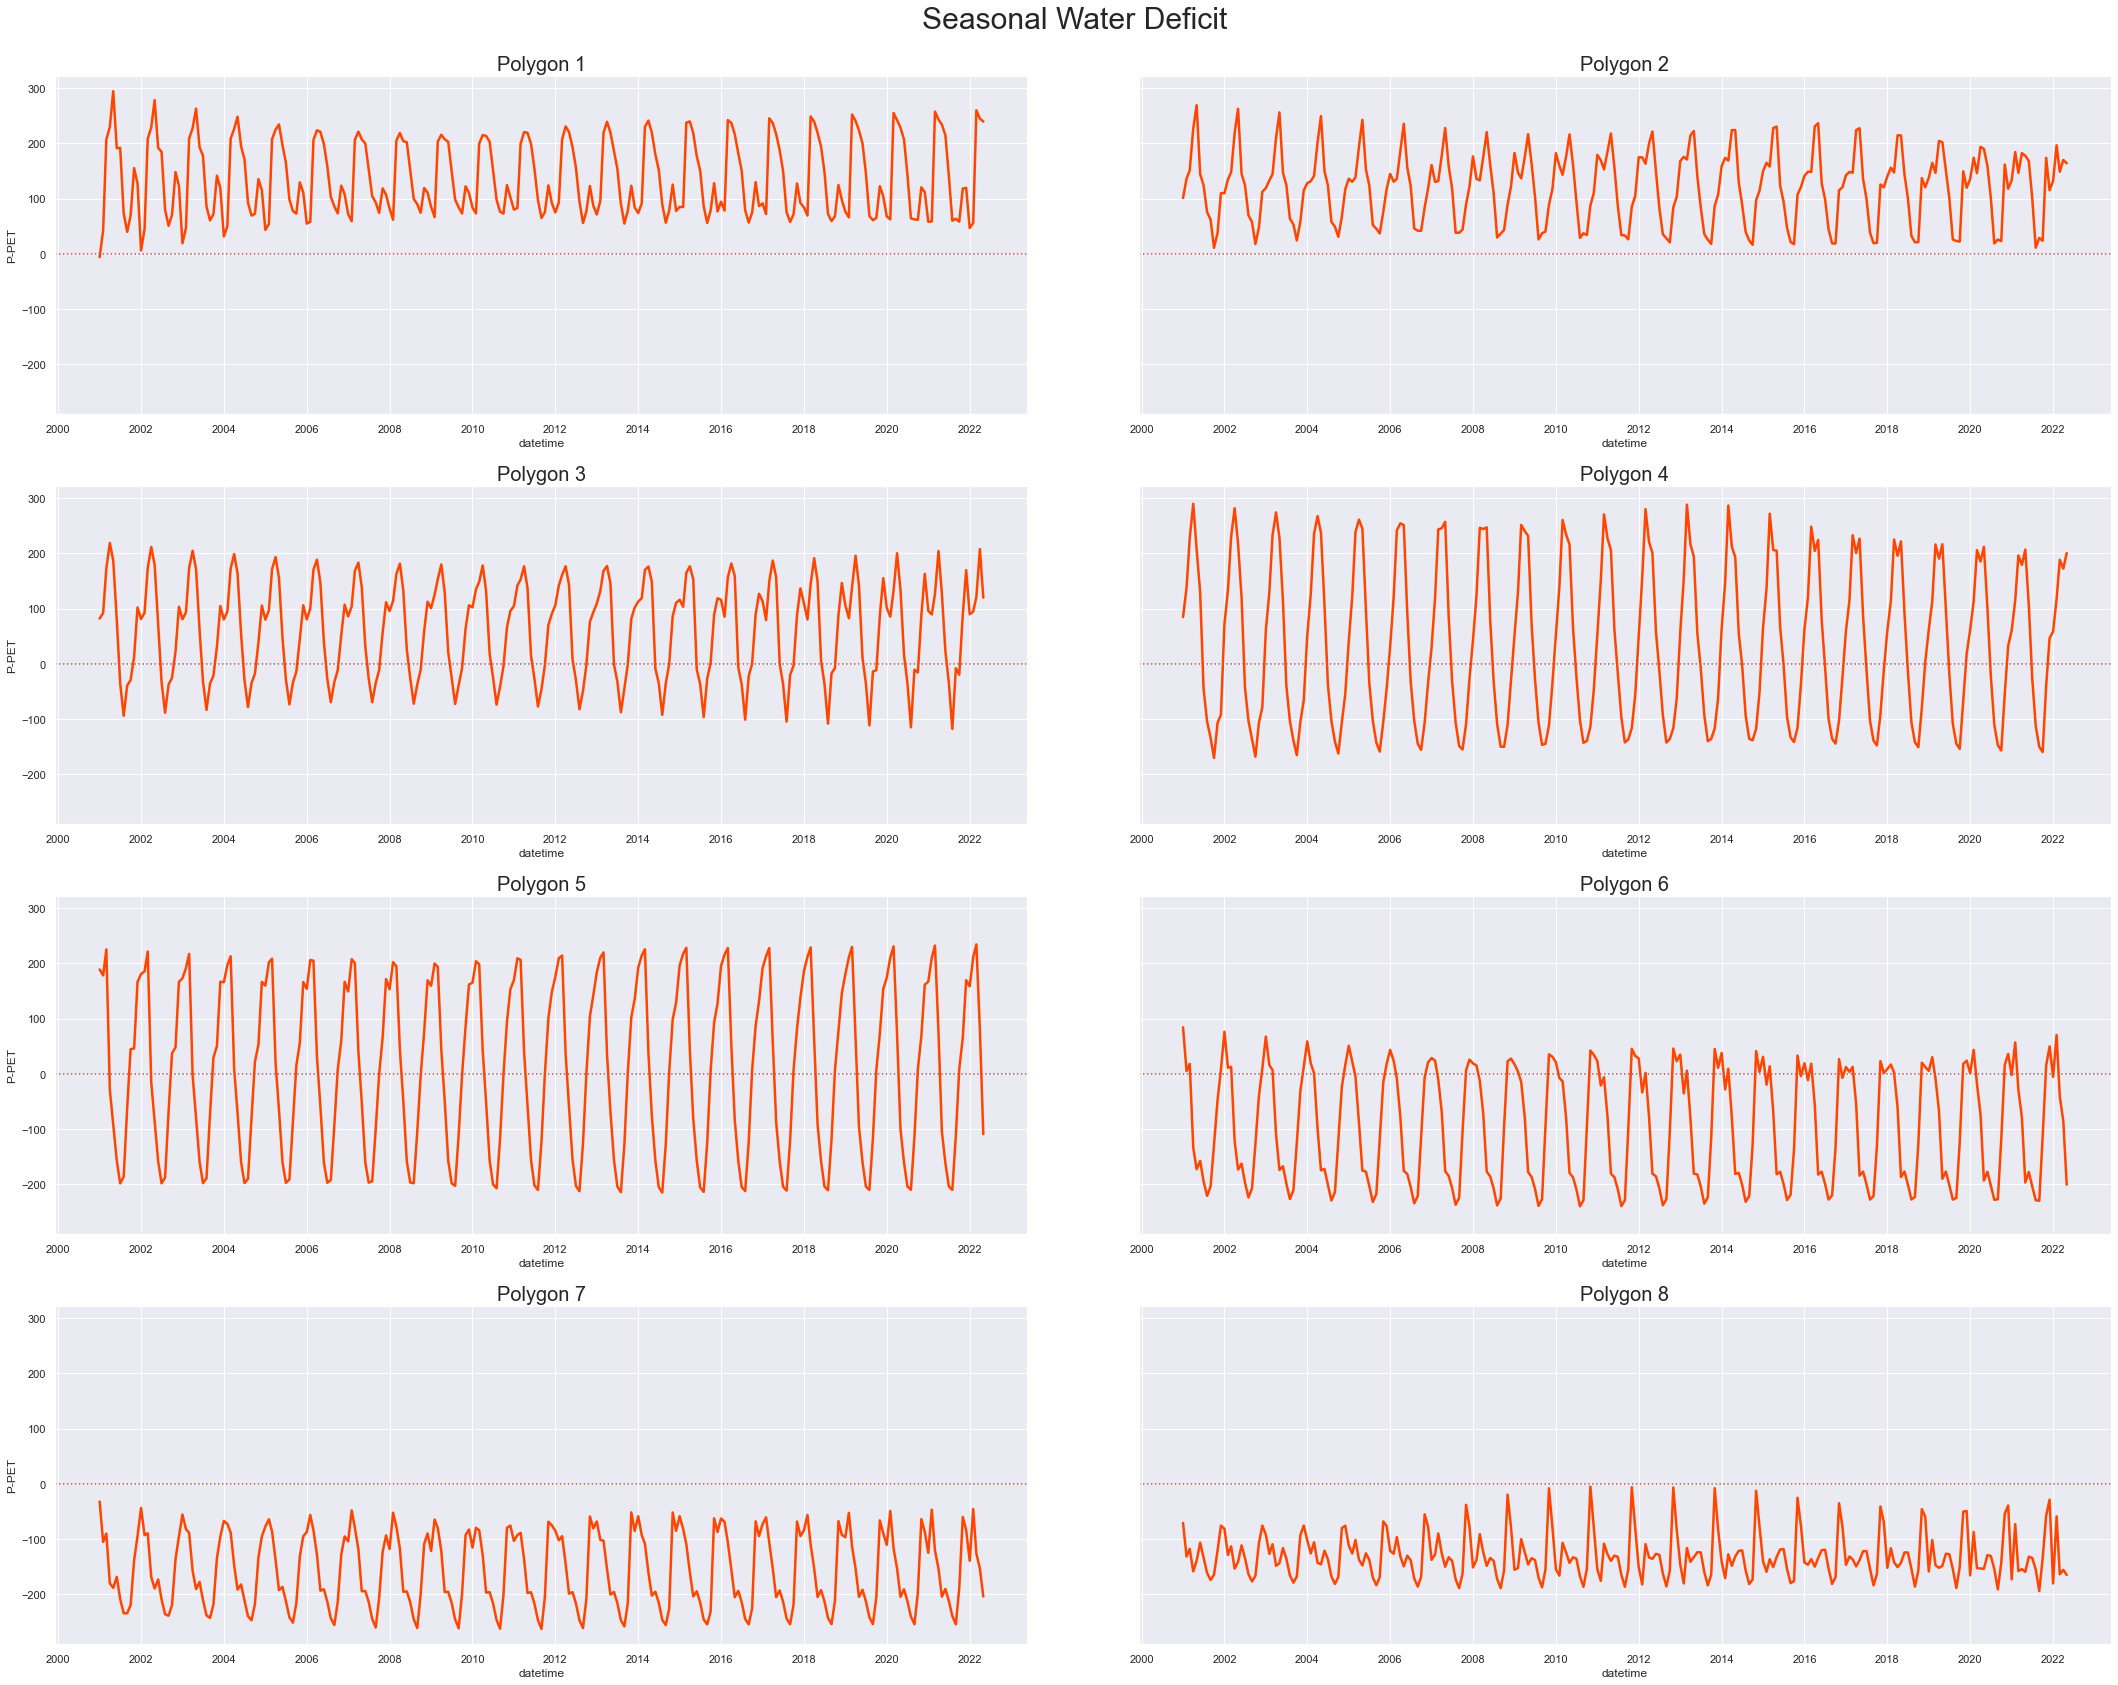

In [83]:
import matplotlib.dates as mdates
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='datetime', y='P-PET', ax=ax, linewidth=2.5, color='orangered'), title='Seasonal Water Deficit', sharey=True)
for lala in ax:
    for bla in lala:
        bla.axhline(y=0, color = 'r', linestyle = 'dotted')
        locator = mdates.AutoDateLocator(minticks=10, maxticks=17)
        bla.xaxis.set_major_locator(locator) 
        bla.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator)) 

##### Polygon 1

In [85]:
# Polygon 1.
join_polygon_1 = join_and_shift_data(climate_seasonal, gedi_seasonal, 1)
get_correlations(join_polygon_1).head()

pai                1.000000
fpar_2            -0.605712
precipitation_2    0.597863
fpar_-2            0.595838
P-PET_-2          -0.588194
Name: pai, dtype: float64

Seasonal pai negatively correlates with 2 month delayed FPAR, and positively with 2 month delayed precipitation.

<AxesSubplot: xlabel='date', ylabel='precipitation'>

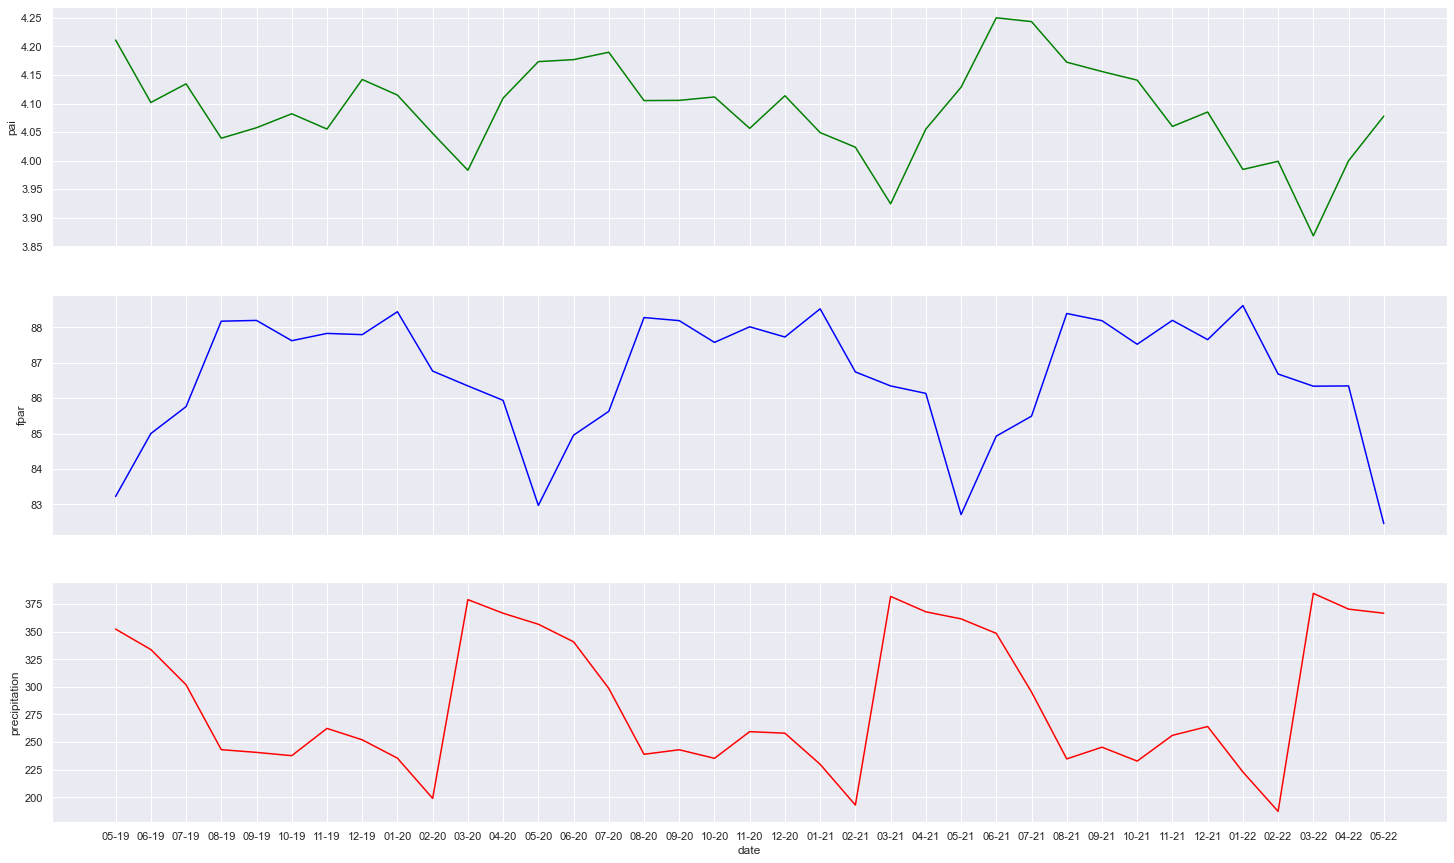

In [86]:
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)

# Plot
sns.lineplot(join_polygon_1, x='date', y='pai', color='green', ax=ax[0])
sns.lineplot(join_polygon_1, x='date', y='fpar', color='blue', ax=ax[1])
sns.lineplot(join_polygon_1, x='date', y='precipitation', color='red', ax=ax[2])


<AxesSubplot: xlabel='month', ylabel='pai'>

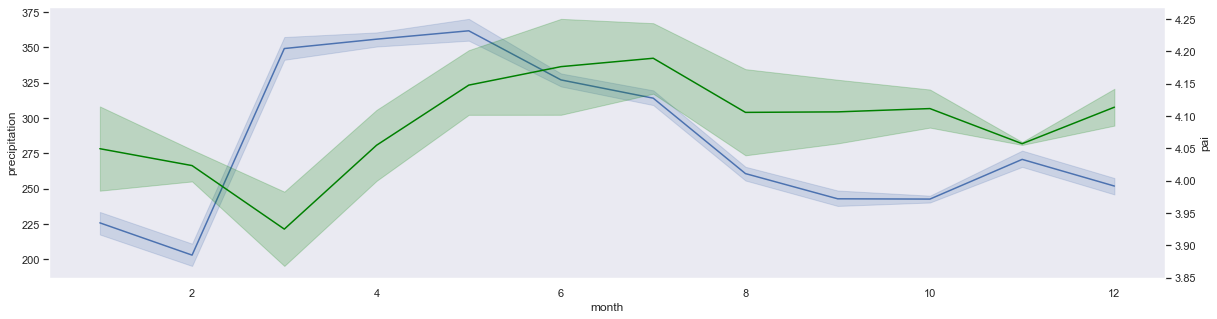

In [87]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==1], x='month', y='precipitation', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_1, x='month', y='pai', ax=twin_ax, color='green')

<AxesSubplot: xlabel='month', ylabel='pai'>

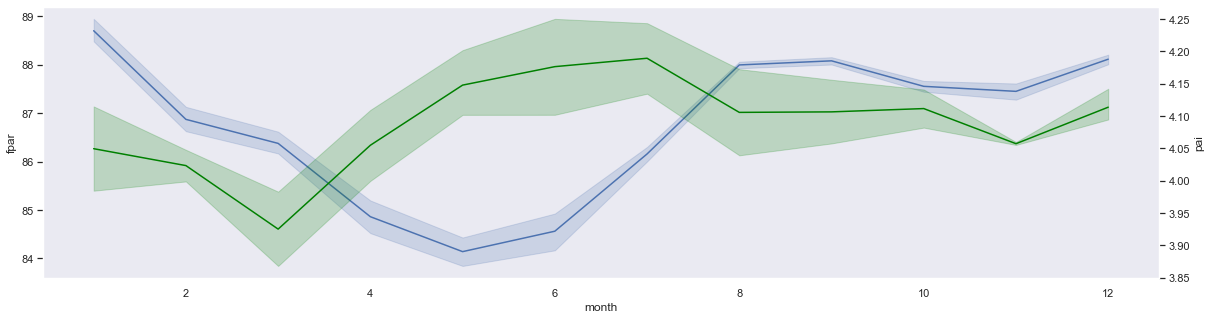

In [88]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==1], x='month', y='fpar', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_1, x='month', y='pai', ax=twin_ax, color='green')

In [89]:
# Polygon 1 - correlations in the original signal
get_correlations(join_and_shift_data(climate, gedi, 1))

pai                 1.000000
radiation_-2        0.424658
fpar_2             -0.421890
P-PET_-2           -0.385404
radiation_1        -0.364825
precipitation_-2   -0.348953
precipitation_1     0.337205
radiation_2        -0.314593
temperature        -0.308967
P-PET_1             0.304857
P-PET_-1           -0.287222
fpar_-2             0.279362
temperature_1      -0.260228
precipitation_-1   -0.253907
month               0.249890
temperature_-1     -0.241335
fpar_1             -0.210526
P-PET_2             0.209893
precipitation_2     0.176089
temperature_2      -0.175055
fpar               -0.167759
radiation          -0.150948
P-PET              -0.111806
precipitation      -0.097321
fpar_-1             0.057967
radiation_-1        0.043034
temperature_-2      0.020997
Name: pai, dtype: float64

##### Polygon 2

In [90]:
# Polygon 2.
join_polygon_2 = join_and_shift_data(climate_seasonal, gedi_seasonal, 2)
get_correlations(join_polygon_2).head()

pai                1.000000
precipitation_1    0.555915
month             -0.552272
P-PET_2            0.545408
P-PET_1            0.515754
Name: pai, dtype: float64

Seasonal PAI negatively correlates with 2 month delayed radiation, and positively with 2 month delayed water deficit. As we start exiting the water deficit, so does vegetation start growing with a 2 month delay, at least in the seasonal signal.

<AxesSubplot: xlabel='date', ylabel='P-PET'>

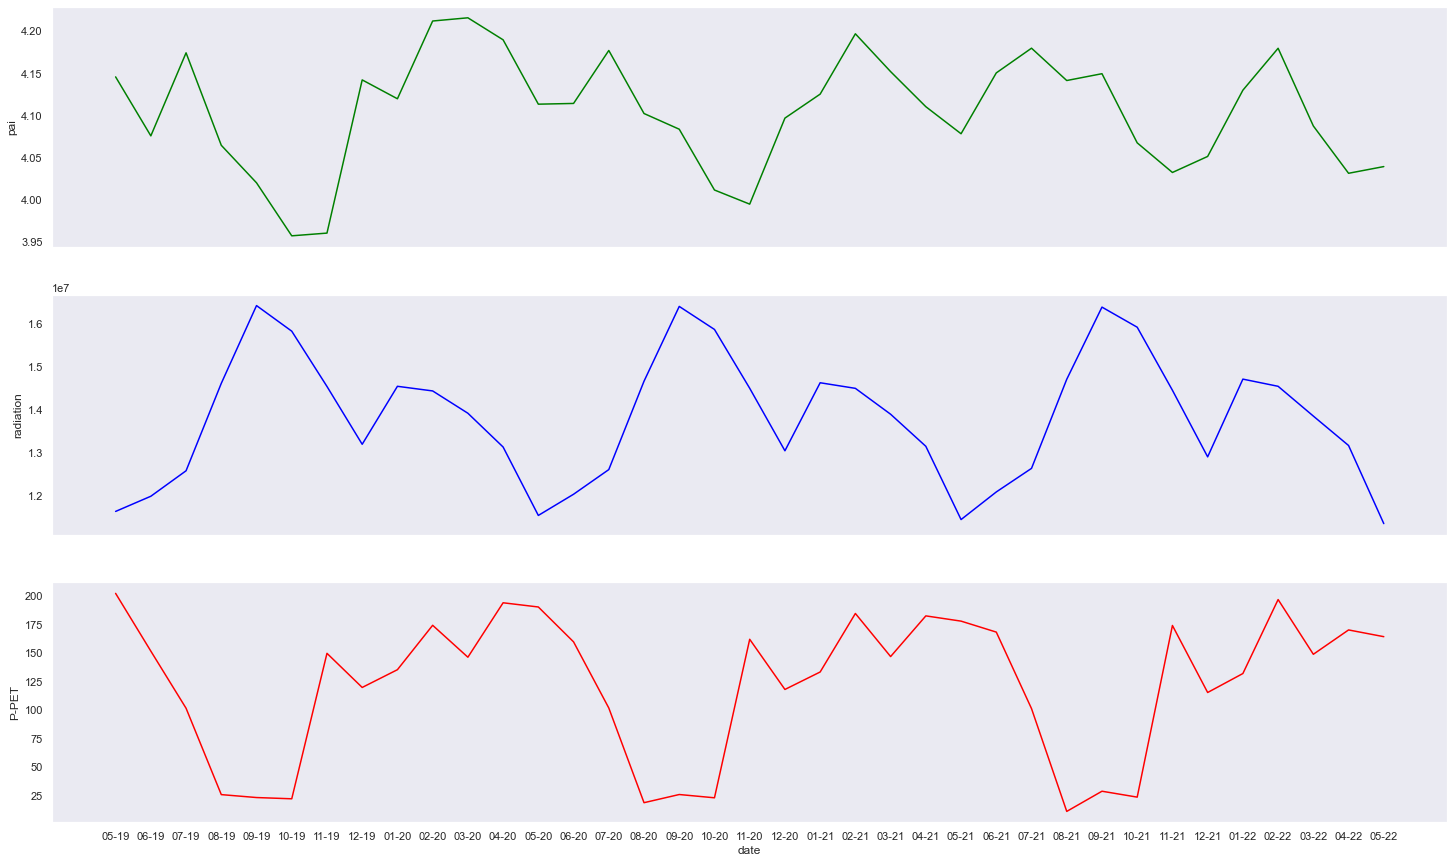

In [91]:
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)

# Plot
sns.lineplot(join_polygon_2, x='date', y='pai', color='green', ax=ax[0])
sns.lineplot(join_polygon_2, x='date', y='radiation', color='blue', ax=ax[1])
sns.lineplot(join_polygon_2, x='date', y='P-PET', color='red', ax=ax[2])

<AxesSubplot: xlabel='month', ylabel='pai'>

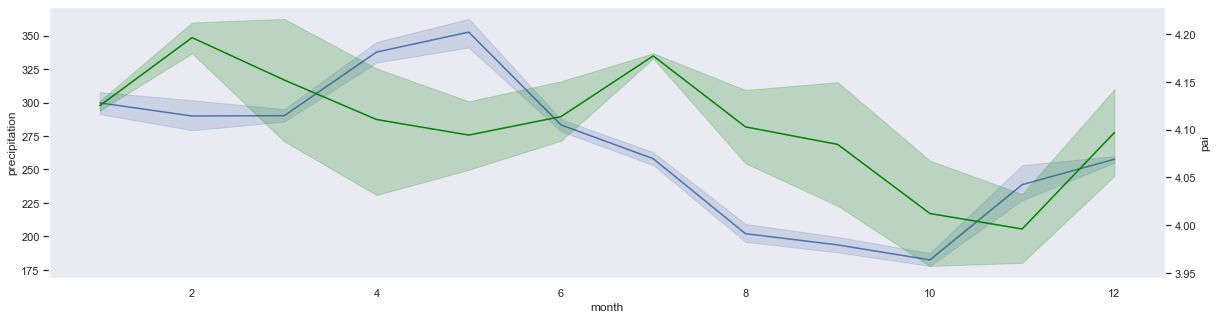

In [92]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==2], x='month', y='precipitation', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_2, x='month', y='pai', ax=twin_ax, color='green')

In [93]:
# Polygon 2 - correlations in the original signal
join_polygon_1 = join_and_shift_data(climate, gedi, 2)
get_correlations(join_polygon_1)

pai                 1.000000
radiation_2        -0.374315
radiation_1        -0.358574
P-PET_-2           -0.289889
precipitation_-2   -0.270525
fpar                0.237882
temperature_1      -0.210587
month              -0.208735
fpar_-1             0.194166
radiation          -0.186305
temperature        -0.168100
temperature_2      -0.137580
P-PET_2             0.133336
precipitation       0.130877
precipitation_2     0.119364
fpar_2             -0.110270
precipitation_1     0.107870
fpar_-2             0.104177
P-PET_1             0.100289
P-PET               0.095175
P-PET_-1           -0.084396
fpar_1             -0.057137
precipitation_-1   -0.054877
radiation_-2        0.045483
temperature_-2      0.045334
radiation_-1       -0.038257
temperature_-1      0.032256
Name: pai, dtype: float64

##### Polygon 4

In [94]:
# Polygon 4.
join_polygon_4 = join_and_shift_data(climate_seasonal, gedi_seasonal, 4)
get_correlations(join_polygon_4)

pai                 1.000000
precipitation_-2   -0.820743
radiation_-1        0.803075
P-PET_-2           -0.800942
fpar_-1             0.791691
P-PET_-1           -0.778013
fpar_-2             0.741667
radiation_-2        0.741285
precipitation_-1   -0.739215
temperature_-2      0.727170
temperature_-1      0.709840
fpar                0.591980
radiation           0.580289
P-PET              -0.576112
precipitation      -0.507489
temperature         0.423470
month               0.354925
precipitation_2     0.338384
P-PET_2             0.255030
fpar_1              0.247242
radiation_1         0.225821
temperature_2      -0.221467
radiation_2        -0.193773
fpar_2             -0.182747
P-PET_1            -0.177644
temperature_1       0.148906
precipitation_1    -0.085654
Name: pai, dtype: float64

We see the biggest correlation with precipitation and fpar shifted by 2 months into the future. Why? Does this make any sense? I think the problem is that it's dificult to see seasonality in pai data in this polygon, possibly due to outlier data still present - like the first deep dip.

<AxesSubplot: xlabel='date', ylabel='radiation'>

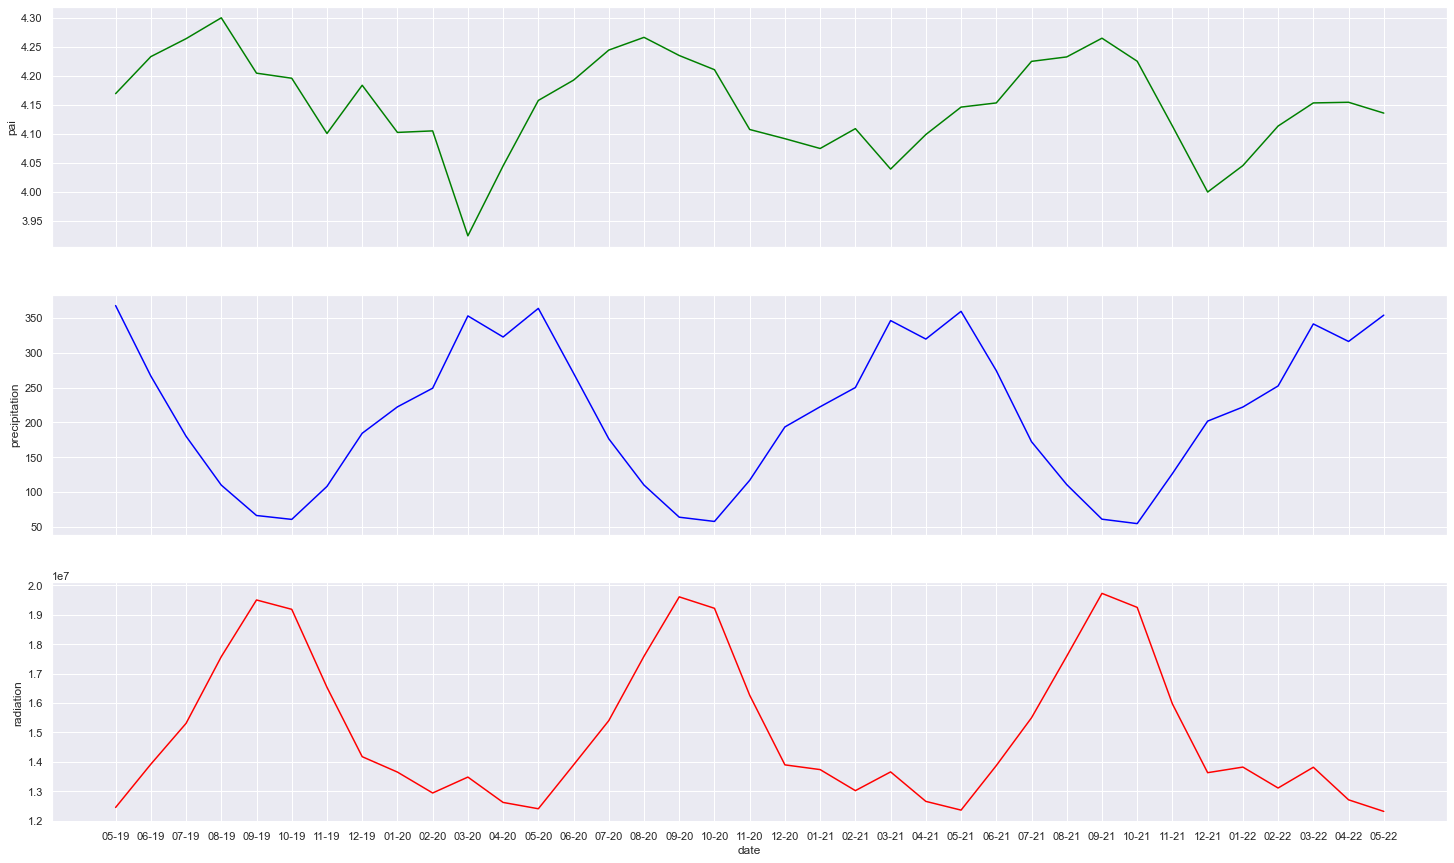

In [95]:
sns.set_style({'axes.grid' : True})
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)

# Plot
sns.lineplot(join_polygon_4, x='date', y='pai', color='green', ax=ax[0])
sns.lineplot(join_polygon_4, x='date', y='precipitation', color='blue', ax=ax[1])
sns.lineplot(join_polygon_4, x='date', y='radiation', color='red', ax=ax[2])

<AxesSubplot: xlabel='month', ylabel='pai'>

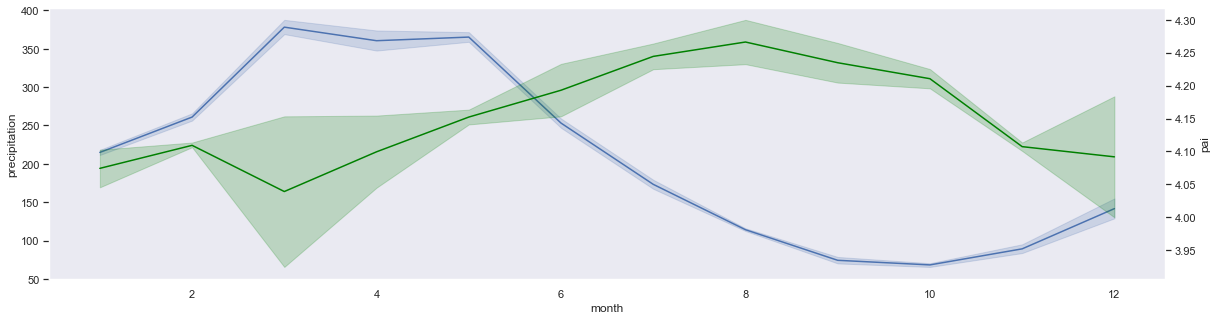

In [96]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==4], x='month', y='precipitation', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_4, x='month', y='pai', ax=twin_ax, color='green')

In [257]:
# Polygon 4 - correlations in the original signal
join_polygon_4 = join_and_shift_data(climate, gedi, 4)
get_correlations(join_polygon_4)

pai_interpolated    1.000000
P-PET_-2           -0.786862
precipitation_-2   -0.782900
radiation_-1        0.733390
radiation_-2        0.723912
P-PET_-1           -0.722349
precipitation_-1   -0.677472
temperature_-2      0.564753
fpar_-2             0.543032
radiation           0.492751
fpar_-1             0.479152
temperature_-1      0.474918
P-PET              -0.448448
precipitation      -0.388522
fpar                0.322103
radiation_1         0.284408
P-PET_1            -0.203652
temperature         0.190595
precipitation_2     0.181225
fpar_2             -0.173341
precipitation_1    -0.132948
P-PET_2             0.101120
temperature_1       0.085267
temperature_2      -0.079383
fpar_1              0.033425
radiation_2        -0.008385
Name: pai_interpolated, dtype: float64

##### Polygon 5

In [97]:
# Polygon 5.
join_polygon_5 = join_and_shift_data(climate_seasonal, gedi_seasonal, 5)
get_correlations(join_polygon_5).head()

pai                 1.000000
P-PET_-2           -0.815163
P-PET_-1           -0.793496
precipitation_-1   -0.790648
precipitation_-2   -0.787714
Name: pai, dtype: float64

Vegetation is clearly positively correlated with radiation, and negatively with precipitation. This seems like the obvious example of the green up fenomenon.

<AxesSubplot: xlabel='date', ylabel='precipitation'>

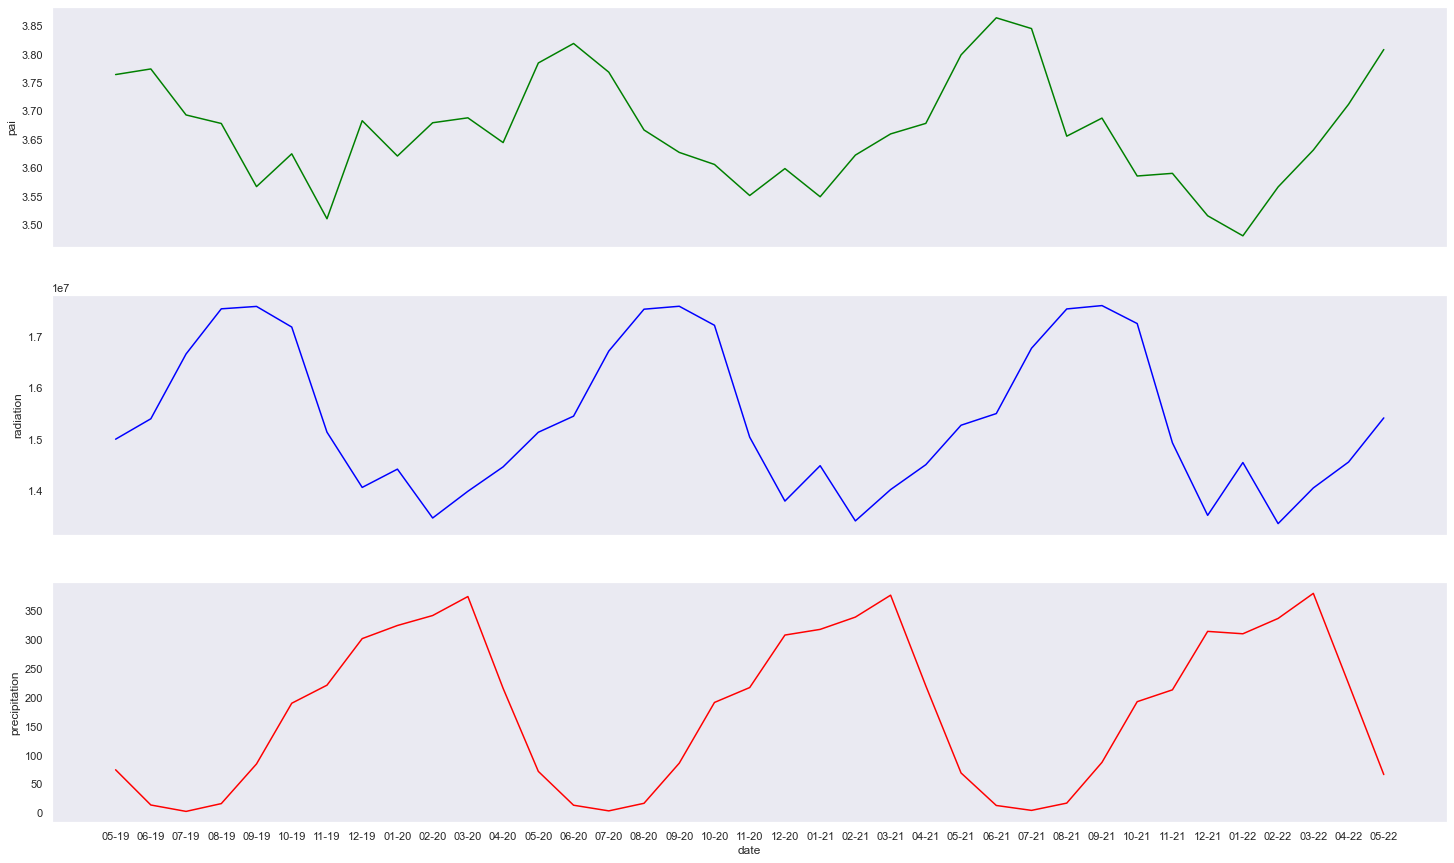

In [98]:
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)

# Plot
sns.lineplot(join_polygon_5, x='date', y='pai', color='green', ax=ax[0])
sns.lineplot(join_polygon_5, x='date', y='radiation', color='blue', ax=ax[1])
sns.lineplot(join_polygon_5, x='date', y='precipitation', color='red', ax=ax[2])

<AxesSubplot: xlabel='month', ylabel='pai'>

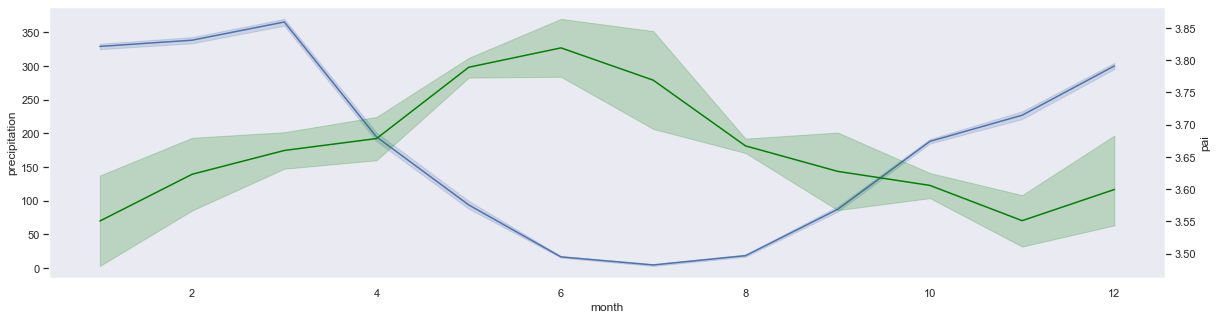

In [99]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==5], x='month', y='precipitation', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_5, x='month', y='pai', ax=twin_ax, color='green')

In [100]:
# Polygon 5 - correlations in the original signal
join_polygon_5 = join_and_shift_data(climate, gedi, 5)
get_correlations(join_polygon_5)

pai                 1.000000
precipitation_-1   -0.710086
P-PET_-1           -0.706559
P-PET_-2           -0.673614
precipitation_-2   -0.646708
precipitation      -0.592064
P-PET              -0.558152
temperature_1      -0.531775
temperature_2      -0.529870
radiation_-2        0.515507
fpar_-1             0.462350
temperature        -0.389319
radiation_-1        0.368163
fpar                0.365682
fpar_-2             0.330646
temperature_-2      0.316104
precipitation_1    -0.313042
radiation_2        -0.287750
P-PET_1            -0.264982
fpar_1              0.172150
P-PET_2             0.146399
radiation           0.134202
precipitation_2     0.119141
temperature_-1     -0.101130
month              -0.073562
radiation_1        -0.065907
fpar_2             -0.044717
Name: pai, dtype: float64

##### Polygon 6

In [101]:
# Polygon 6.
join_polygon_6 = join_and_shift_data(climate_seasonal, gedi_seasonal, 6)
get_correlations(join_polygon_6)

pai                 1.000000
P-PET               0.872300
precipitation_1     0.864922
P-PET_1             0.855636
precipitation       0.837116
fpar_-1             0.819971
fpar                0.766846
temperature_-2     -0.739684
temperature_-1     -0.735658
fpar_-2             0.669087
radiation_-1       -0.623984
temperature_2       0.614762
precipitation_2     0.613060
P-PET_-1            0.592877
precipitation_-1    0.550610
radiation          -0.545841
P-PET_2             0.517384
radiation_-2       -0.508288
temperature        -0.479457
fpar_1              0.466894
radiation_2         0.427920
month              -0.228131
P-PET_-2            0.199855
radiation_1        -0.169652
precipitation_-2    0.150543
temperature_1       0.052819
fpar_2             -0.049038
Name: pai, dtype: float64

Positively correlated with precipitation and water deficit. In this polygon, vegetation seasonality seems primarely driven by water availability. Also highly correlated with fpar. Question, why is fpar the opposite of radiation?

<AxesSubplot: xlabel='date', ylabel='precipitation'>

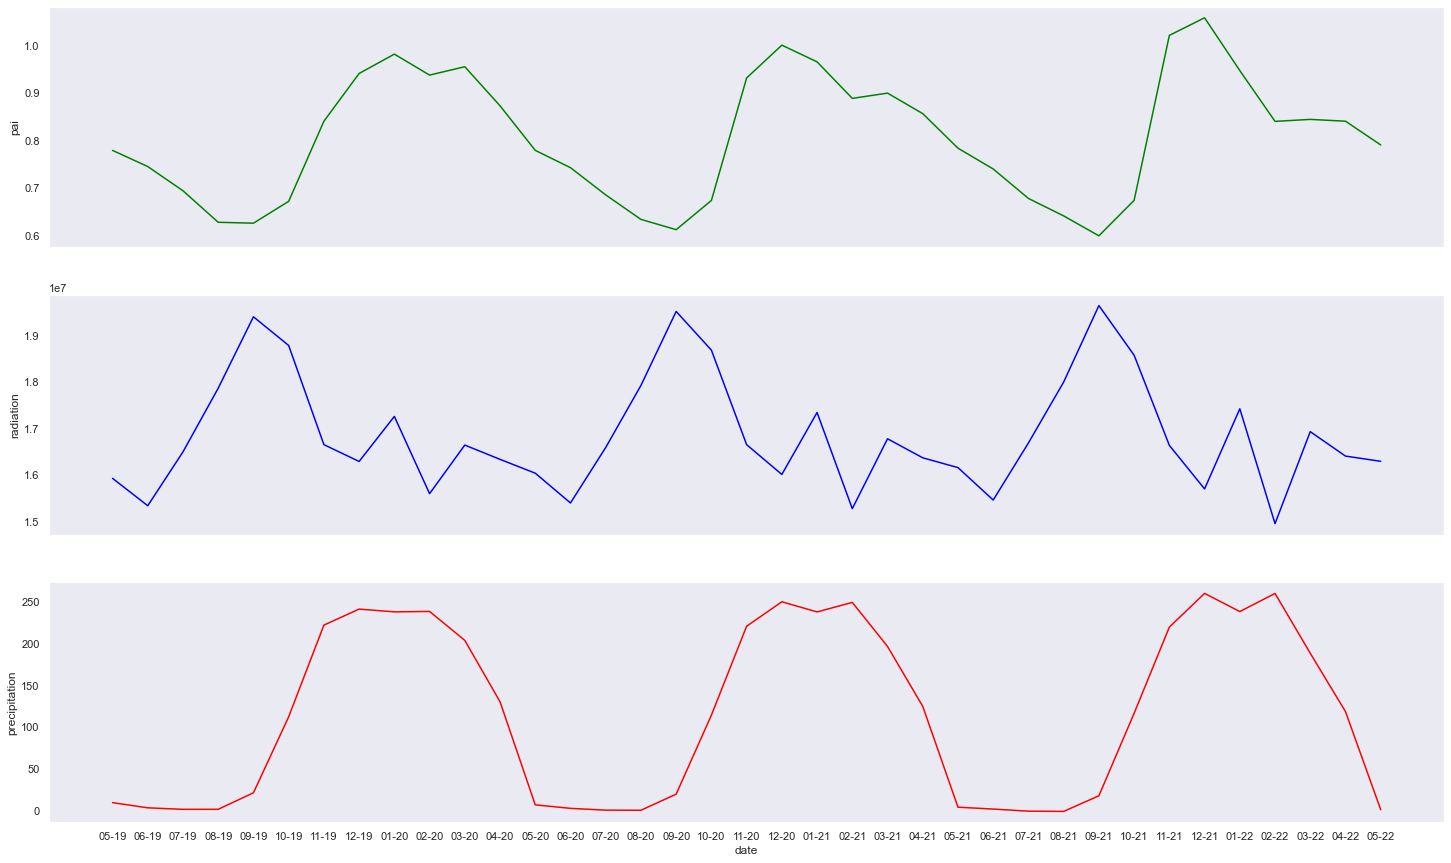

In [102]:
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)

# Plot
sns.lineplot(join_polygon_6, x='date', y='pai', color='green', ax=ax[0])
sns.lineplot(join_polygon_6, x='date', y='radiation', color='blue', ax=ax[1])
sns.lineplot(join_polygon_6, x='date', y='precipitation', color='red', ax=ax[2])

<AxesSubplot: xlabel='month', ylabel='pai'>

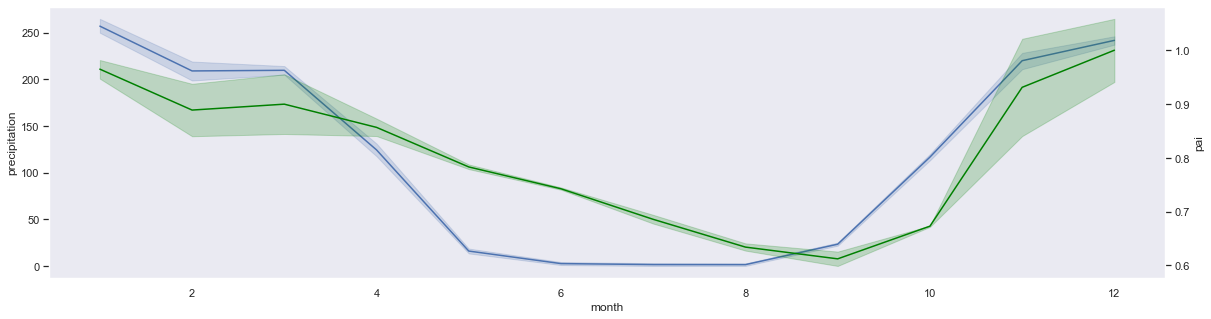

In [103]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==6], x='month', y='precipitation', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_6, x='month', y='pai', ax=twin_ax, color='green')

In [104]:
# Polygon 6 - correlations in the original signal
join_polygon_6 = join_and_shift_data(climate, gedi, 6)
get_correlations(join_polygon_6)

pai                 1.000000
fpar_-1             0.768542
precipitation_1     0.707798
temperature_-2     -0.702706
precipitation       0.700909
fpar                0.688470
P-PET               0.686651
temperature_-1     -0.684068
fpar_-2             0.653691
P-PET_1             0.649876
P-PET_-1            0.530892
precipitation_2     0.528596
precipitation_-1    0.519101
temperature_2       0.513906
radiation_-1       -0.453177
fpar_1              0.446271
temperature        -0.436756
P-PET_2             0.415241
radiation          -0.344694
radiation_-2       -0.317058
radiation_2         0.288461
month              -0.229521
P-PET_-2            0.177137
precipitation_-2    0.139590
radiation_1        -0.065720
temperature_1       0.019866
fpar_2             -0.014007
Name: pai, dtype: float64

##### Polygon 7

In [105]:
# Polygon 7.
join_polygon_7 = join_and_shift_data(climate_seasonal, gedi_seasonal, 7)
get_correlations(join_polygon_7)

pai                 1.000000
precipitation_1     0.916642
fpar_-1             0.899928
P-PET               0.892151
precipitation       0.859979
fpar                0.844722
P-PET_1             0.822558
temperature_-2     -0.813950
temperature_-1     -0.797762
fpar_-2             0.716724
precipitation_2     0.699281
radiation_2         0.626402
P-PET_-1            0.596291
radiation_-2       -0.572229
temperature_2       0.523461
radiation_-1       -0.506664
temperature        -0.503397
fpar_1              0.499375
P-PET_2             0.491947
precipitation_-1    0.489925
month              -0.356097
radiation          -0.280793
P-PET_-2            0.199255
radiation_1         0.151957
fpar_2              0.040669
temperature_1       0.036700
precipitation_-2    0.033878
Name: pai, dtype: float64

<AxesSubplot: xlabel='date', ylabel='P-PET'>

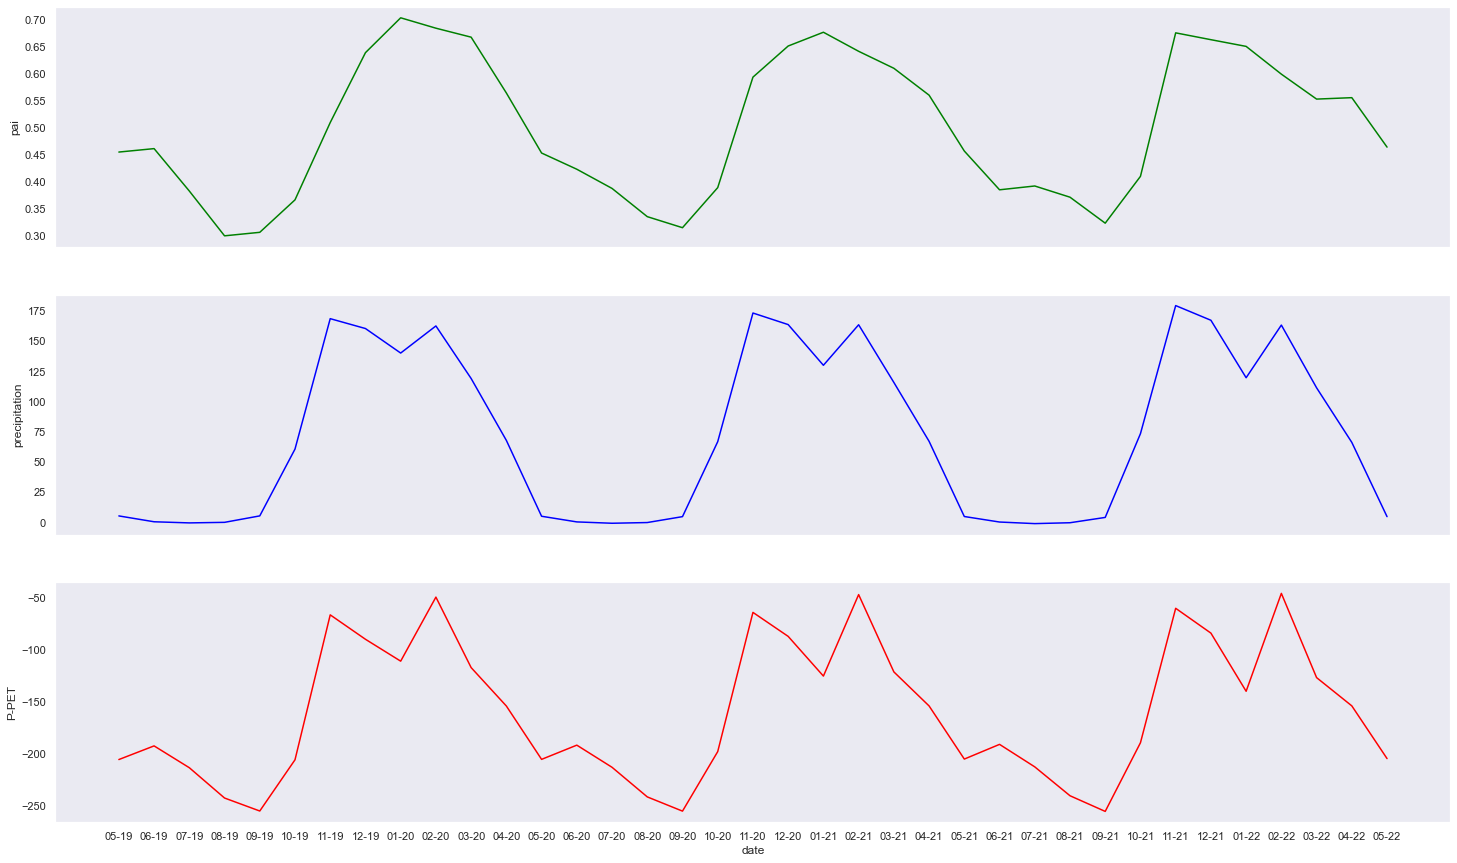

In [106]:
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)

# Plot
sns.lineplot(join_polygon_7, x='date', y='pai', color='green', ax=ax[0])
sns.lineplot(join_polygon_7, x='date', y='precipitation', color='blue', ax=ax[1])
sns.lineplot(join_polygon_7, x='date', y='P-PET', color='red', ax=ax[2])

<AxesSubplot: xlabel='month', ylabel='pai'>

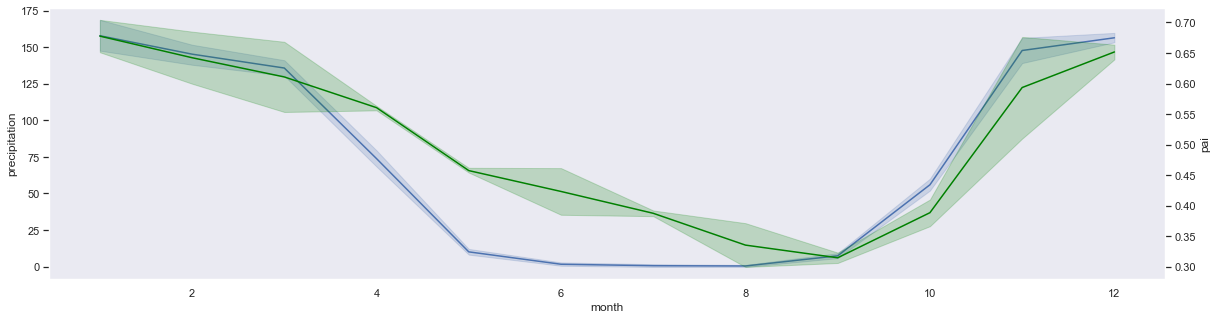

In [107]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==7], x='month', y='precipitation', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_7, x='month', y='pai', ax=twin_ax, color='green')

In [261]:
# Polygon 7 - correlations in the original signal
join_polygon_7 = join_and_shift_data(climate, gedi, 7)
get_correlations(join_polygon_7)

pai_interpolated    1.000000
fpar_-1             0.894000
fpar                0.821587
temperature_-2     -0.763249
temperature_-1     -0.741797
fpar_-2             0.728352
precipitation_1     0.696697
precipitation       0.693541
P-PET               0.670405
P-PET_1             0.563706
precipitation_2     0.543269
temperature        -0.478488
temperature_2       0.474628
fpar_1              0.466074
radiation_2         0.455629
radiation_-2       -0.411807
P-PET_-1            0.411604
radiation_-1       -0.388152
precipitation_-1    0.362014
P-PET_2             0.342041
radiation          -0.249522
radiation_1         0.141724
P-PET_-2            0.076451
fpar_2              0.049778
precipitation_-2   -0.047475
temperature_1       0.046868
Name: pai_interpolated, dtype: float64

##### Polygon 8

In [108]:
# Polygon 8.
join_polygon_8 = join_and_shift_data(climate_seasonal, gedi_seasonal, 8)
get_correlations(join_polygon_8)

pai                 1.000000
fpar                0.842849
precipitation_1     0.769708
precipitation_2     0.755968
fpar_-1             0.722018
radiation_2         0.709614
temperature_2       0.701723
fpar_1              0.638882
temperature_-2     -0.583703
month              -0.571149
P-PET_1             0.547829
temperature_-1     -0.510062
fpar_-2             0.482812
precipitation_-2   -0.449059
P-PET_2             0.441652
radiation_1         0.428615
precipitation       0.372881
P-PET_-2           -0.346399
radiation_-2       -0.325711
temperature        -0.303671
radiation           0.222991
P-PET               0.215774
temperature_1       0.154321
P-PET_-1           -0.124861
fpar_2              0.098978
precipitation_-1   -0.092902
radiation_-1        0.022201
Name: pai, dtype: float64

Polygon 8 vegetation is correlated with delayed 1 month and 2 month precipitation, but not so much with current precipitation. We speculate this is because the area becomes so dry (this polygon spends most of the time in severe water deficit), that it needs 1 to 2 months of water accumulation for the vegetation to start growing.

fpar has the strongest seasonal correlation as well.

<AxesSubplot: xlabel='date', ylabel='fpar'>

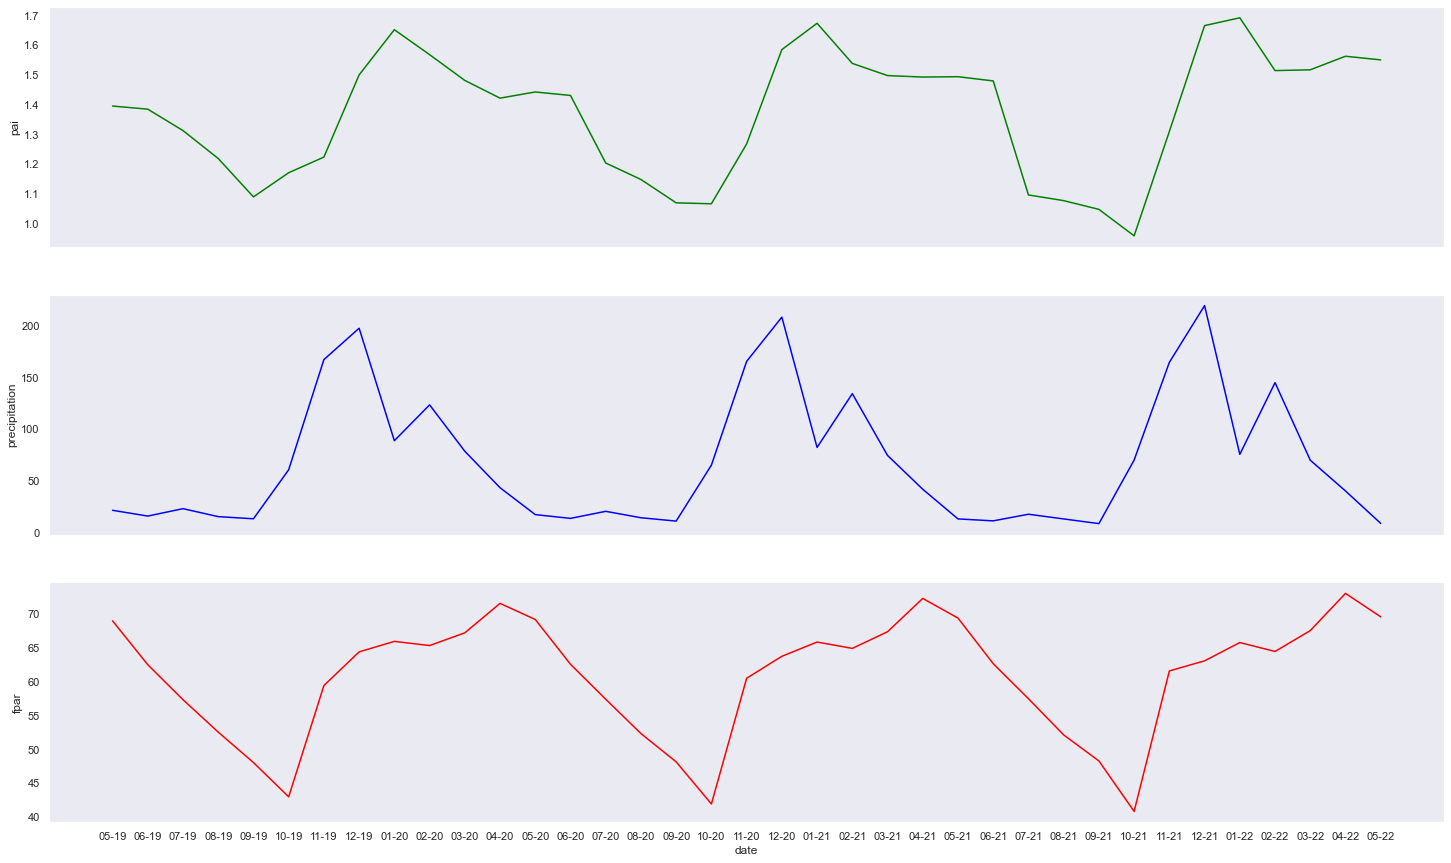

In [109]:
fig, ax = plt.subplots(3, figsize=(25, 15), sharey=False, sharex=True)

# Plot
sns.lineplot(join_polygon_8, x='date', y='pai', color='green', ax=ax[0])
sns.lineplot(join_polygon_8, x='date', y='precipitation', color='blue', ax=ax[1])
sns.lineplot(join_polygon_8, x='date', y='fpar', color='red', ax=ax[2])

<AxesSubplot: xlabel='month', ylabel='pai'>

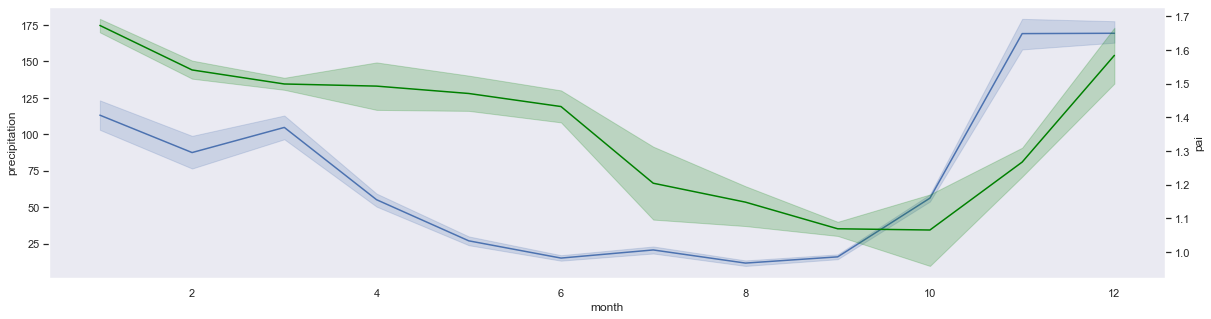

In [110]:
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots()
sns.lineplot(climate_seasonal[climate_seasonal.polygon_id==8], x='month', y='precipitation', ax=ax)
twin_ax = ax.twinx()
sns.lineplot(join_polygon_8, x='month', y='pai', ax=twin_ax, color='green')

In [111]:
# Polygon 8 - correlations in the original signal
join_polygon_8 = join_and_shift_data(climate, gedi, 8)
get_correlations(join_polygon_8)

pai                 1.000000
fpar                0.661168
fpar_-1             0.541909
temperature_-2     -0.539840
fpar_1              0.534113
precipitation_2     0.530750
temperature_2       0.511366
month              -0.497035
radiation_2         0.482815
precipitation_1     0.477026
temperature_-1     -0.471202
fpar_-2             0.403938
precipitation_-2   -0.369981
radiation_1         0.352540
temperature        -0.300380
P-PET_2             0.274637
P-PET_-2           -0.261697
P-PET_1             0.240086
radiation_-2       -0.230798
radiation           0.217754
precipitation       0.205165
fpar_2              0.123314
temperature_1       0.088642
precipitation_-1   -0.073182
P-PET_-1           -0.062681
P-PET               0.061479
radiation_-1       -0.010335
Name: pai, dtype: float64

### Yearly average precipitation vs. PAI

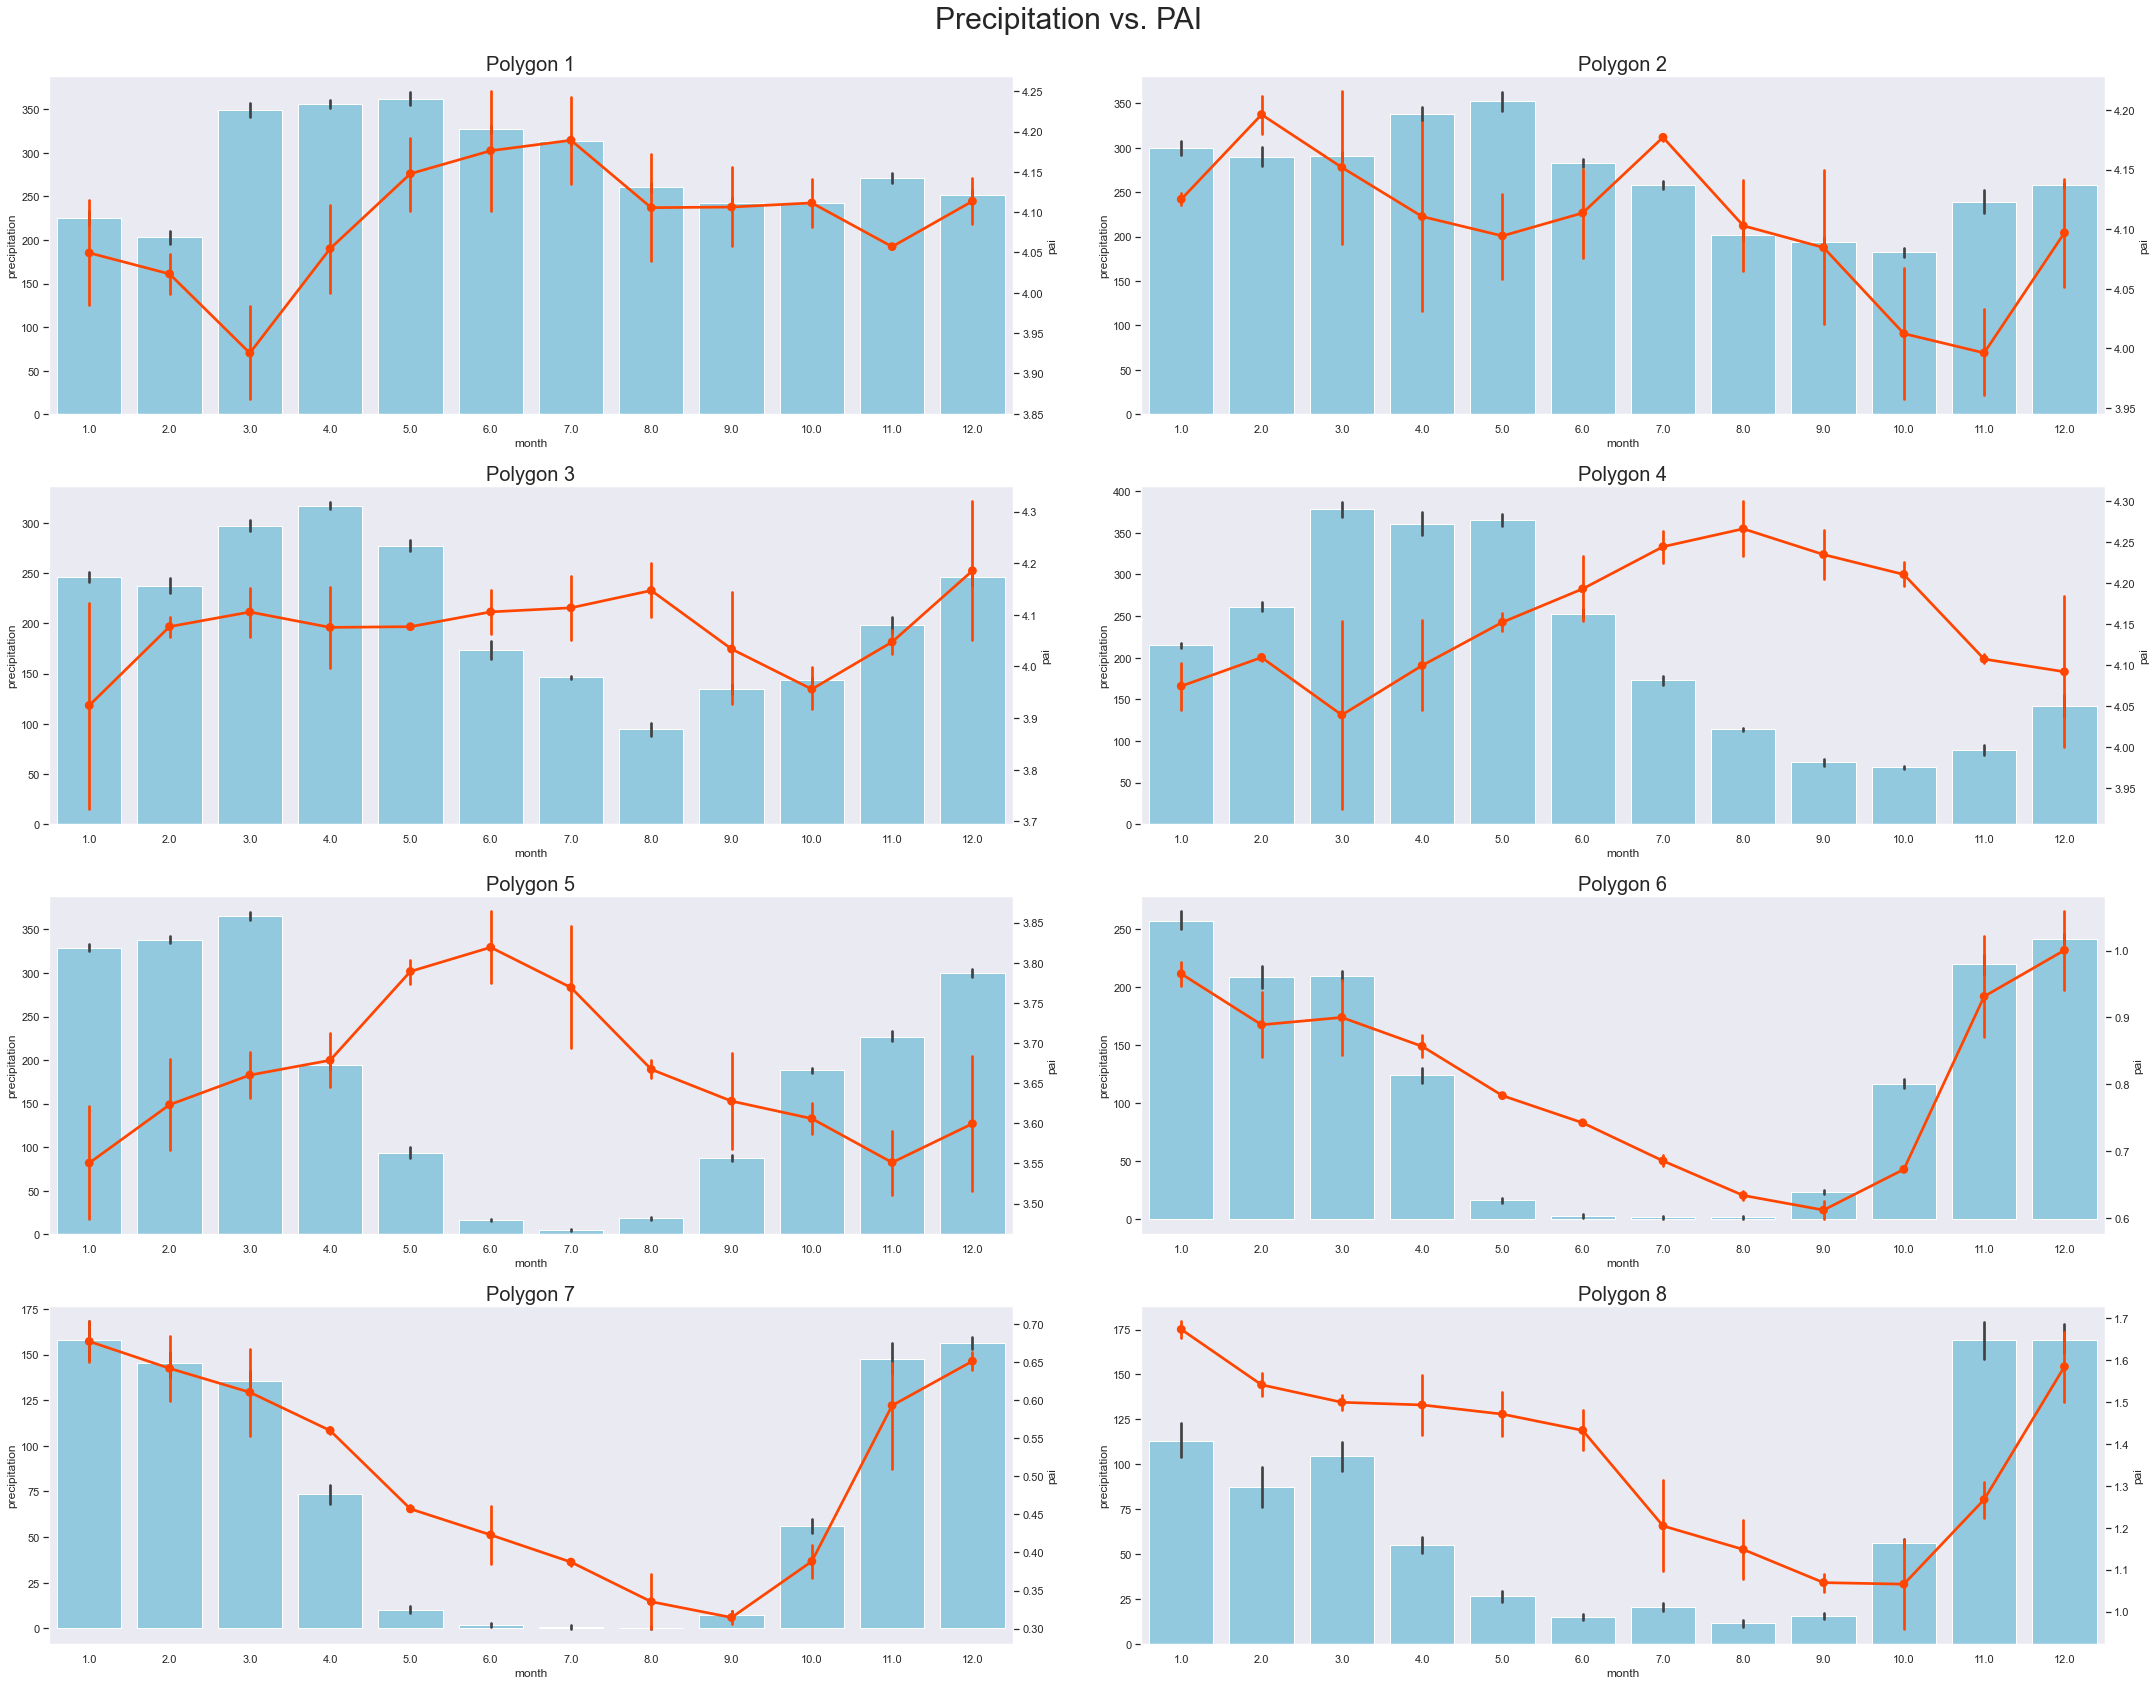

In [112]:
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.barplot(df, x='month', y='precipitation', ax=ax, color='skyblue'), title='Precipitation vs. PAI')
fig, ax = plot.plot_per_polygon(gedi_seasonal, plot_func=lambda df, ax: sns.pointplot(df, x='month', y='pai', ax=ax, color='orangered'), title='Precipitation vs. PAI', twin_axis=True, fig=fig, ax=ax)

In [ ]:
fig, ax = plot.plot_per_polygon(climate_seasonal, plot_func=lambda df, ax: sns.barplot(df, x='month', y='precipitation', ax=ax, color='skyblue'), title='Precipitation vs. PAI')
fig, ax = plot.plot_per_polygon(gedi_seasonal, plot_func=lambda df, ax: sns.pointplot(df, x='month', y='pai', ax=ax, color='orangered'), title='Precipitation vs. PAI', twin_axis=True, fig=fig, ax=ax)

#### Climate vs PAI yearly summary - in plots

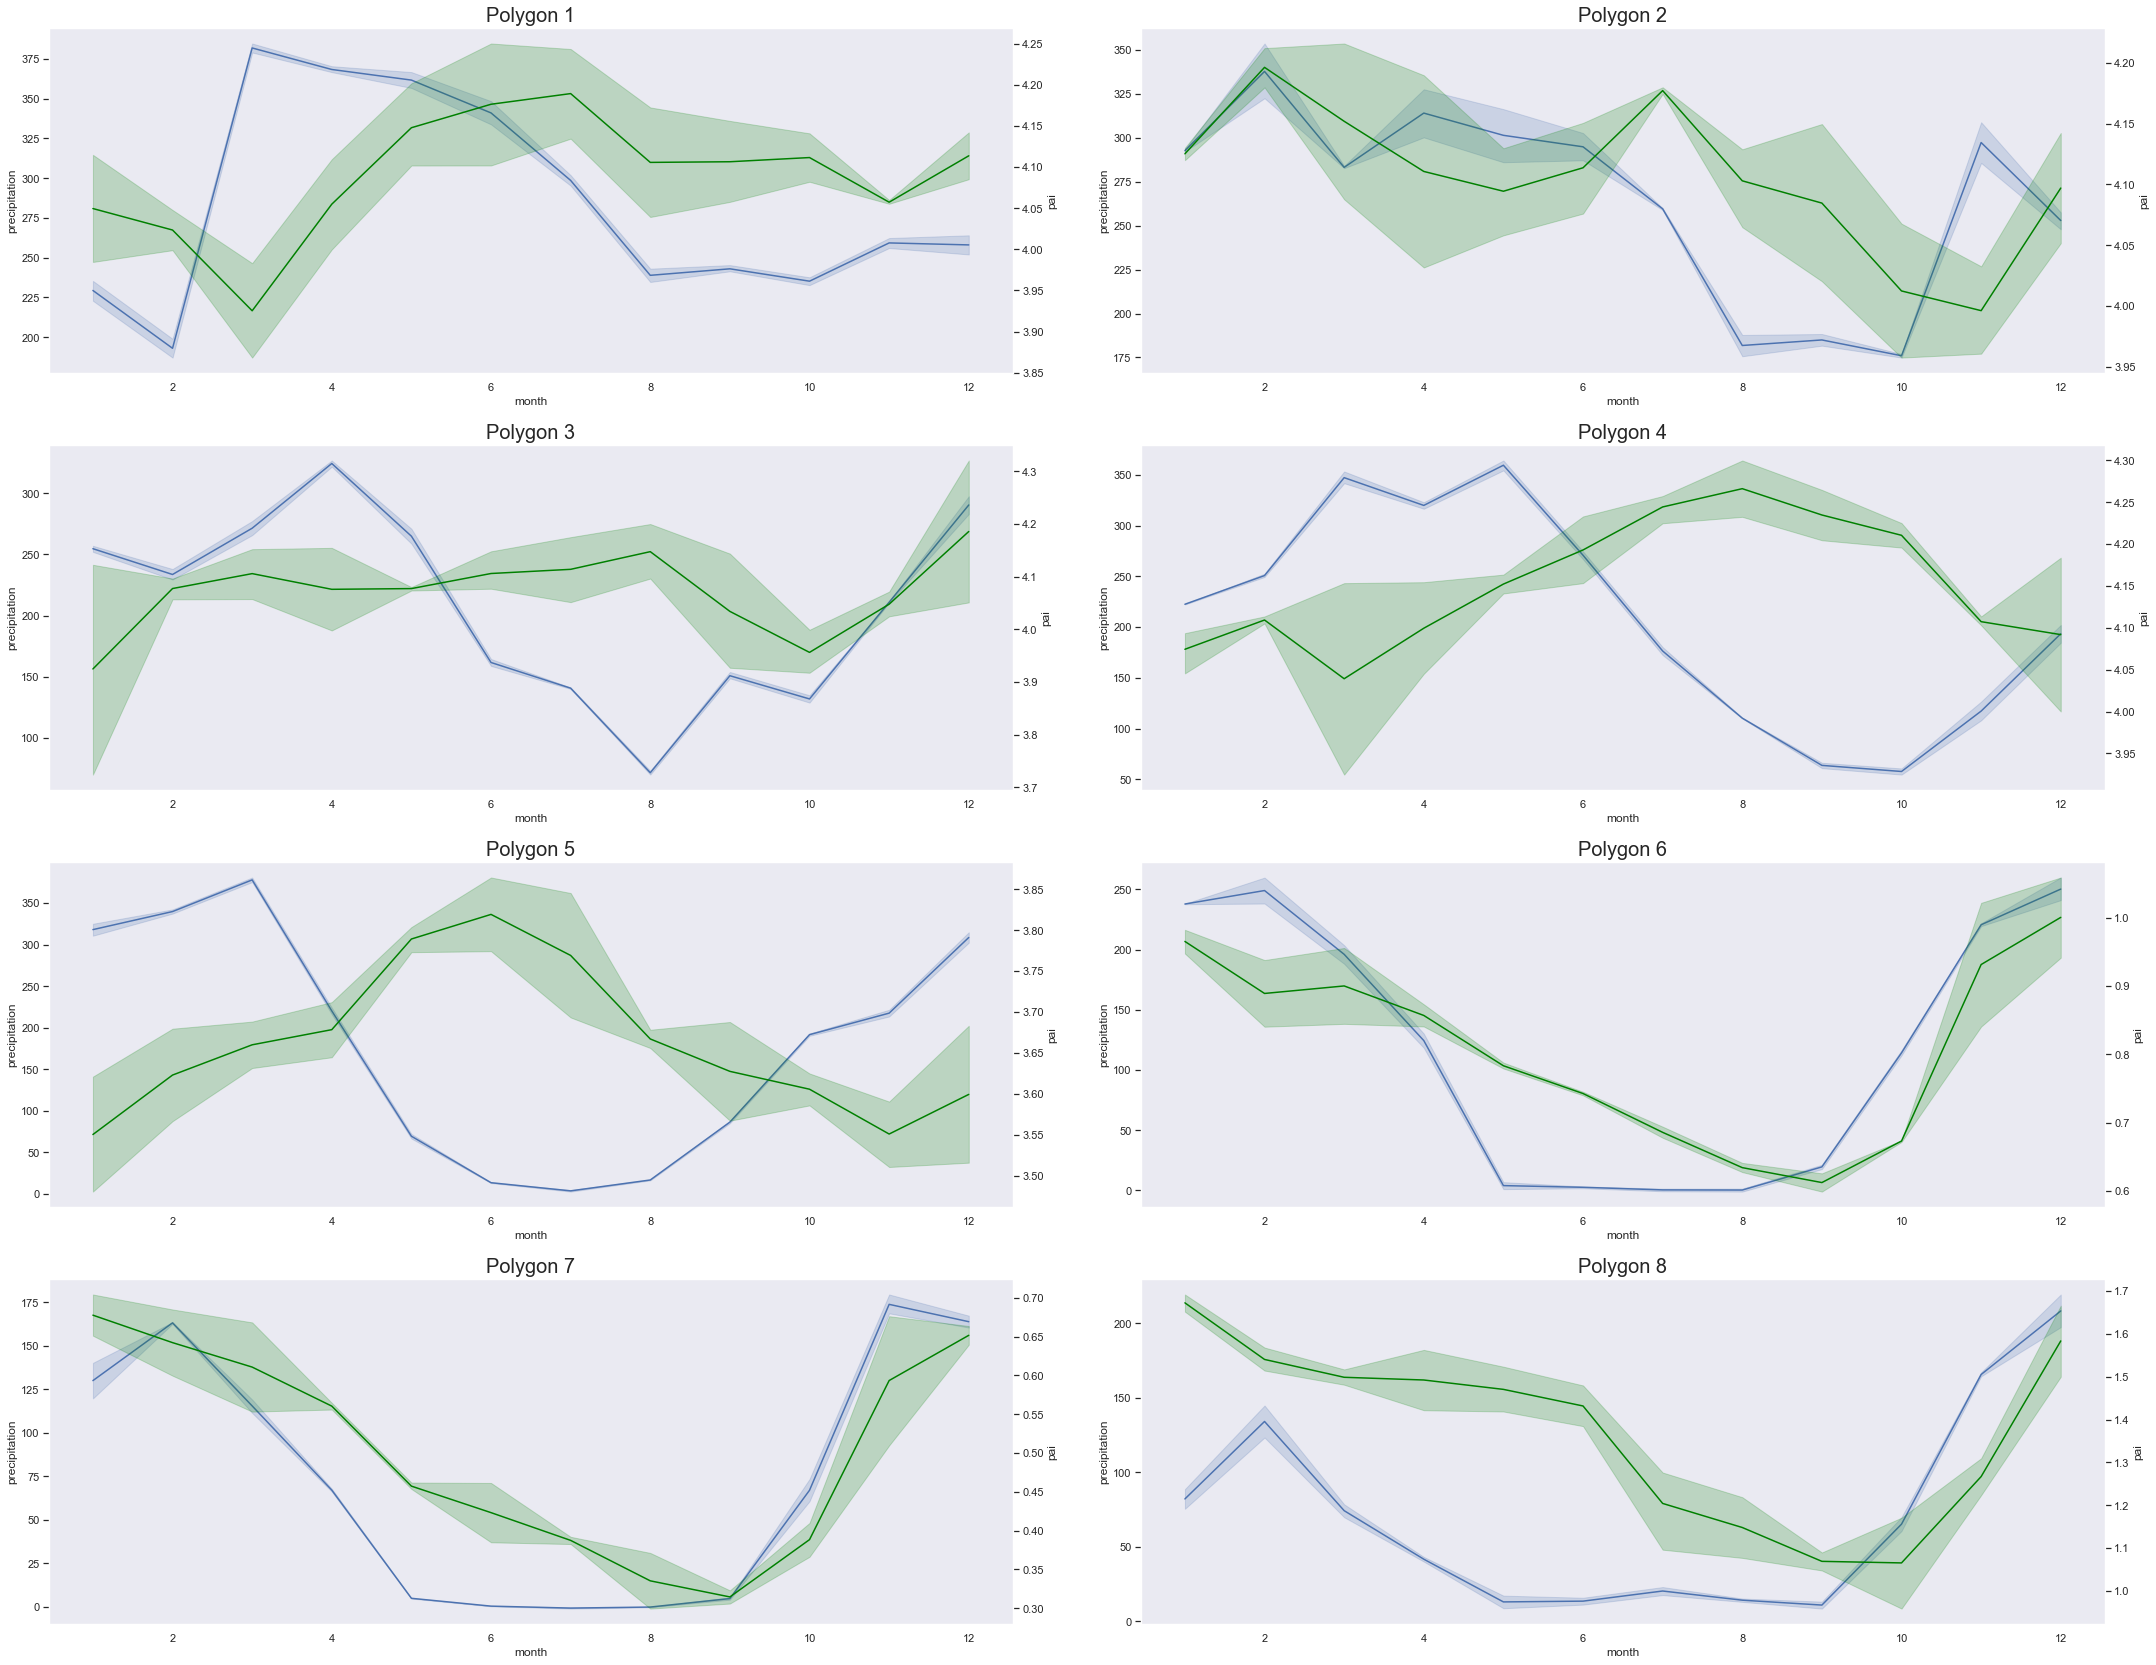

In [113]:
sns.set_style({'axes.grid' : False})
fig, ax = plot.plot_per_polygon(climate_seasonal[climate_seasonal.datetime > gedi_start_date], plot_func=lambda df, ax: sns.lineplot(df, x='month', y='precipitation', ax=ax), title='')
fig, ax = plot.plot_per_polygon(gedi_seasonal, plot_func=lambda df, ax: sns.lineplot(df, x='month', y='pai', ax=ax, color='green'), title='', fig=fig, ax=ax, twin_axis=True)

### Measuring Seasonality Using Timeseries Decomposition

### Plot nrmse for each climate variable

### Methods for doing time series decomposition using statsmodel seasonal

### Per Polygon decomp of water climate vars

## Seasonal decomposition using Fourier

In [126]:
def plot_fft(df, polygon_id, column):
    ts = df[df.polygon_id==polygon_id].sort_values('datetime')[column].to_numpy()
    y_fft = fftpack.fft(ts - ts.mean())
    xf = fftfreq(257, 1/12)
    #return y_fft
    plt.stem(xf, np.abs(y_fft))
    plt.show()
    return y_fft

[]

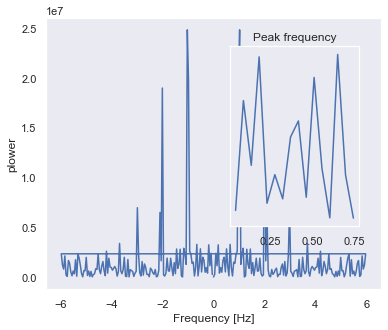

In [123]:
# The FFT of the signal
time_step = 1
y = climate[climate.polygon_id==1].sort_values('datetime').precipitation.to_numpy()
sig_fft = fftpack.fft(y - y.mean())

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2
period = 24

# The corresponding frequencies
sample_freq = fftpack.fftfreq(257, d=1/12)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:16], power[pos_mask][:16])
plt.setp(axes, yticks=[])

/Users/jovanaknezevic/opt/anaconda3/envs/drought/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


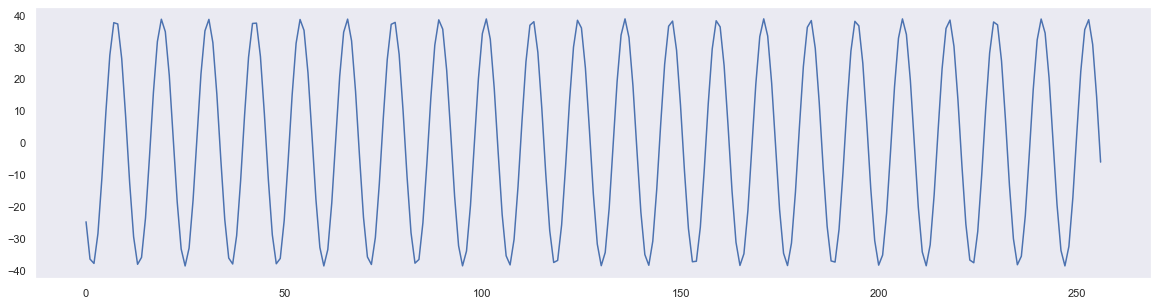

In [124]:
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) != peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)
plt.plot(filtered_sig)
#plt.stem(sample_freq, np.abs(high_freq_fft))
#plt.show()
#filtered_sig = fftpack.ifft(high_freq_fft)

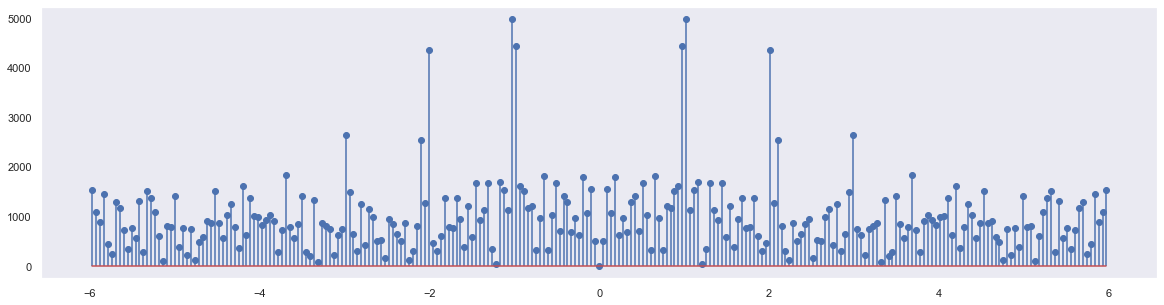

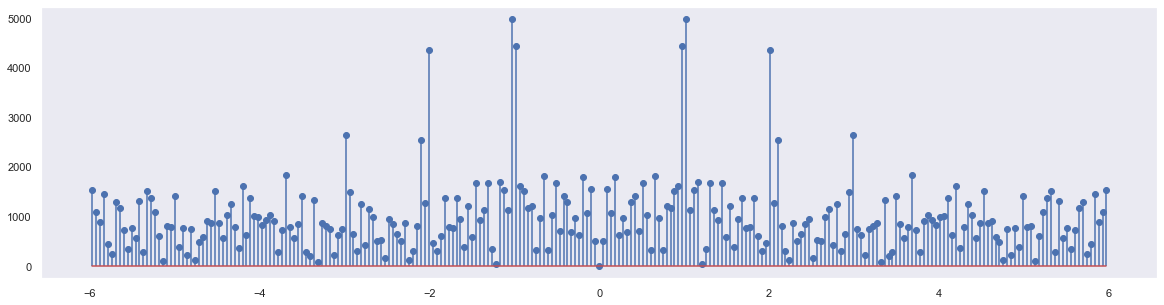

42.833333333333336

In [127]:
SAMPLE_RATE = 12
xf = fftfreq(257, 1/12)
points_per_freq = len(xf) / (SAMPLE_RATE / 2)
target_idx = int(points_per_freq * 100)
yf = plot_fft(climate, 1, 'precipitation')
yf[target_idx - 1 : target_idx + 2] = 0

plt.stem(xf, np.abs(yf))
plt.show()
points_per_freq

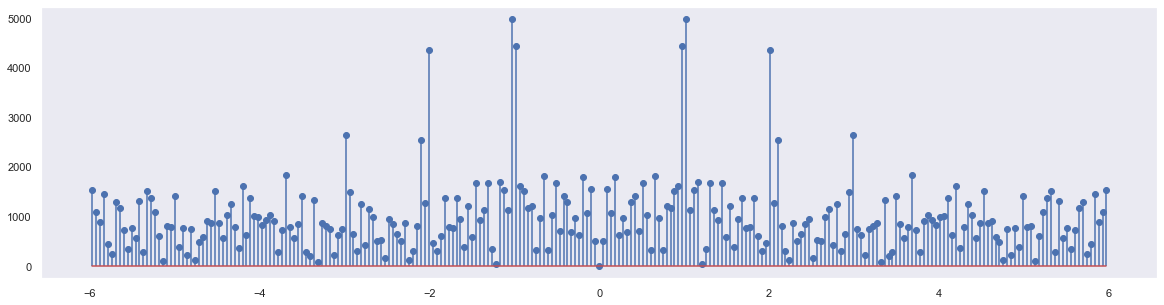

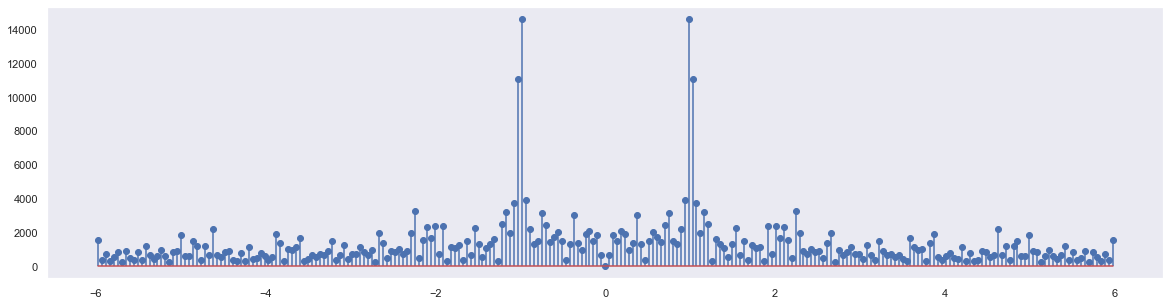

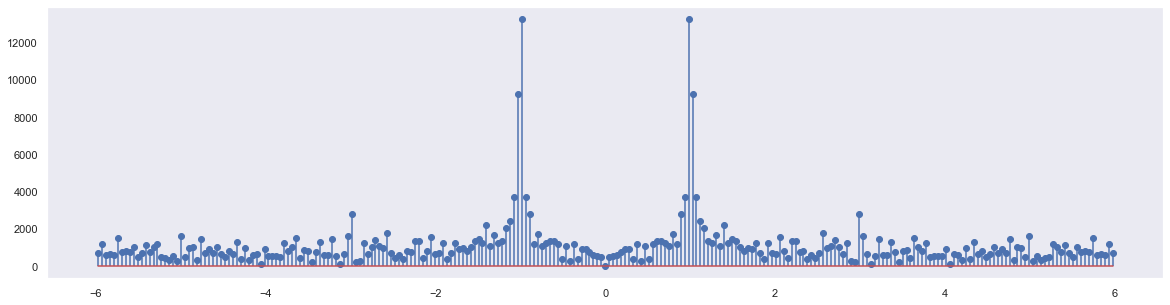

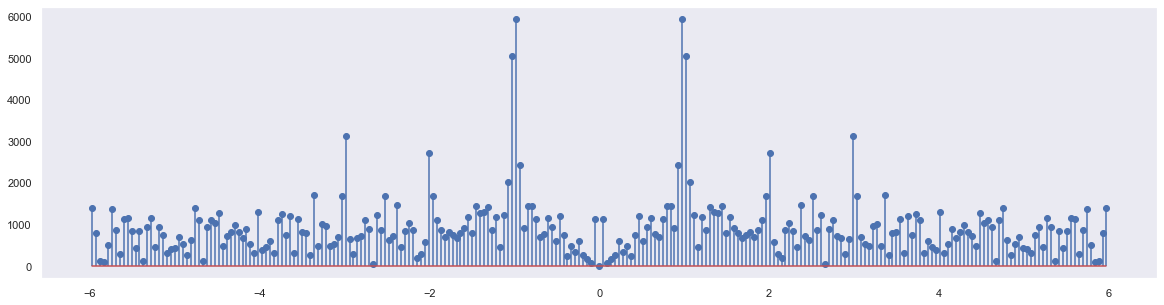

In [128]:
plot_fft(climate, 1, 'precipitation')
plot_fft(climate, 4, 'precipitation')
plot_fft(climate, 6, 'precipitation')
plot_fft(climate, 8, 'precipitation')
plt.show()

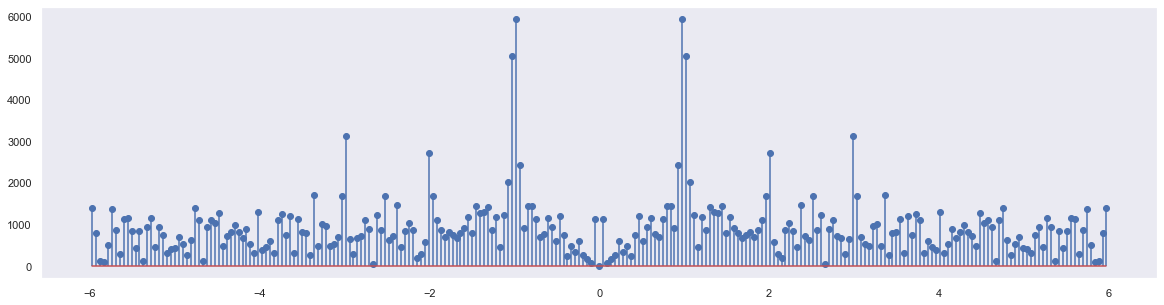

array([ 7.95807864e-13   -0.j        ,  1.12253752e+02-1131.79364737j,
        5.80838533e+01  +39.93715286j,  1.71882374e+02  -33.66206482j,
        1.57510608e+02 +204.2382083j ,  5.82570017e+02 -102.23855855j,
        1.61099684e+02 +298.82379592j,  2.66479703e+02 +410.08904581j,
        2.05371523e+02 -137.12845025j, -5.28855376e+02 -534.04046707j,
       -5.89622438e+02+1050.08369274j,  5.54386238e+00 +596.64295172j,
       -3.10671607e+02 +877.36405892j, -4.92986275e+02+1042.17654919j,
       -4.43435842e+02 +618.18380078j, -2.81235204e+02 +637.59162347j,
       -1.00137804e+03 +517.20549444j, -1.35082931e+03 +531.71535944j,
       -3.27893254e+02+1393.63743334j, -3.59072545e+02 +849.78045872j,
        1.93551880e+02+2424.34467364j,  4.11078382e+02+5926.24397423j,
       -1.17789398e+02-5041.71162245j, -1.11883822e+03-1676.6959304j ,
       -6.53462362e+02-1046.16905605j, -4.01214208e+02 -223.59107092j,
       -2.13394942e+02-1147.99353843j,  7.16083356e+01 -860.58589089j,
      

In [129]:
plot_fft(climate, 8, 'precipitation')

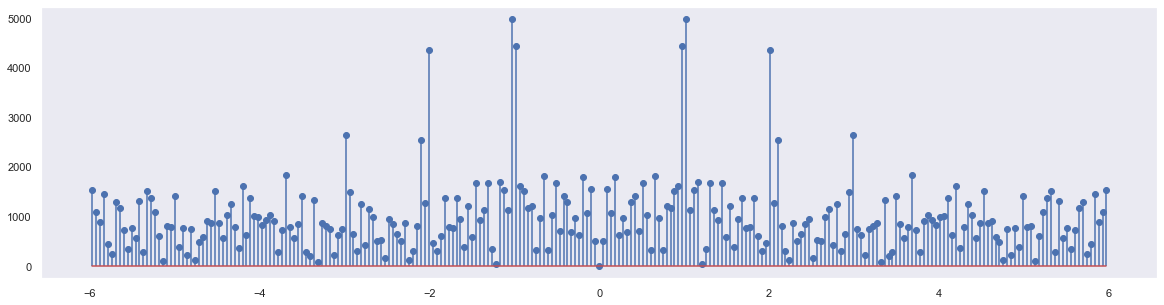

In [130]:
precip_ts = climate[climate.polygon_id==1].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts - precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

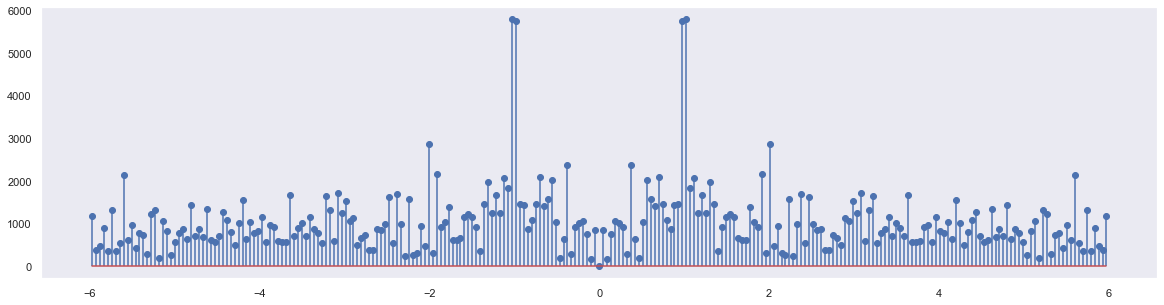

In [132]:
precip_ts = climate[climate.polygon_id==2].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts - precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

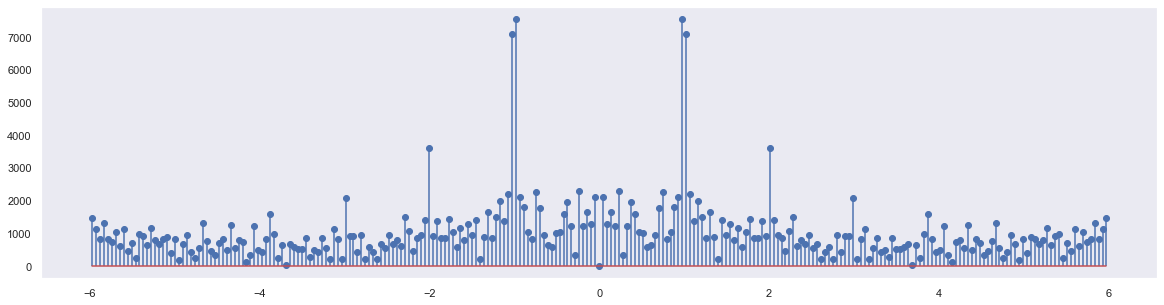

In [134]:
precip_ts = climate[climate.polygon_id==3].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts- precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

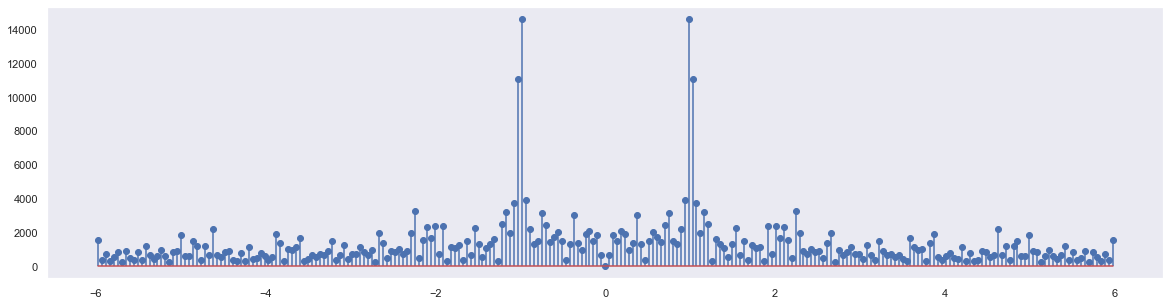

In [135]:
precip_ts = climate[climate.polygon_id==4].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts- precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

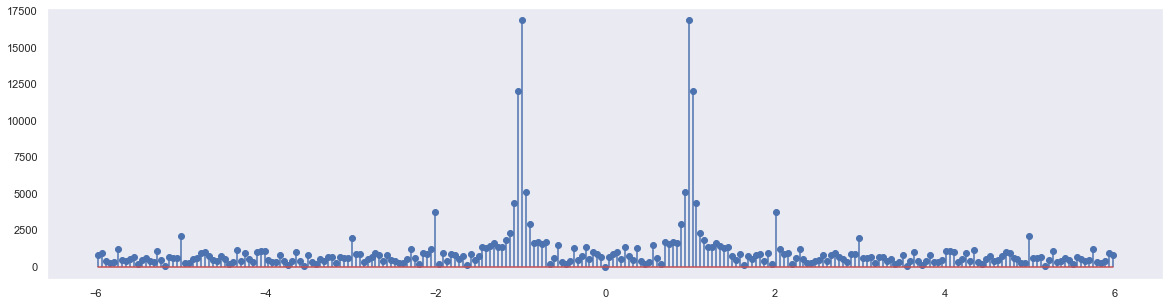

In [136]:
precip_ts = climate[climate.polygon_id==5].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts- precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

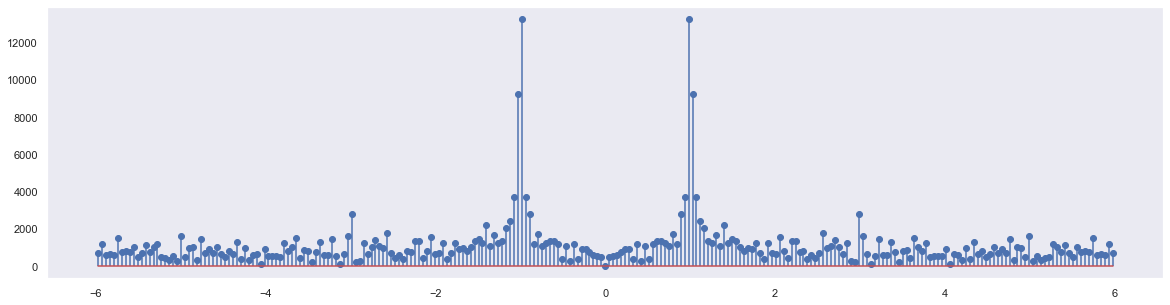

In [137]:
precip_ts = climate[climate.polygon_id==6].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts- precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

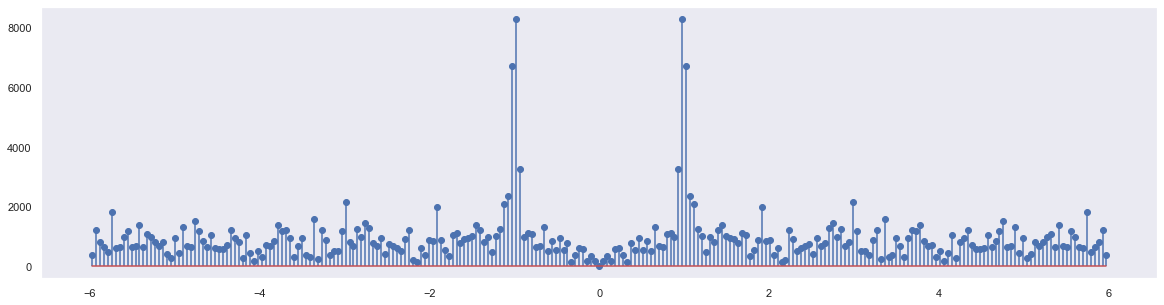

In [138]:
precip_ts = climate[climate.polygon_id==7].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts- precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()

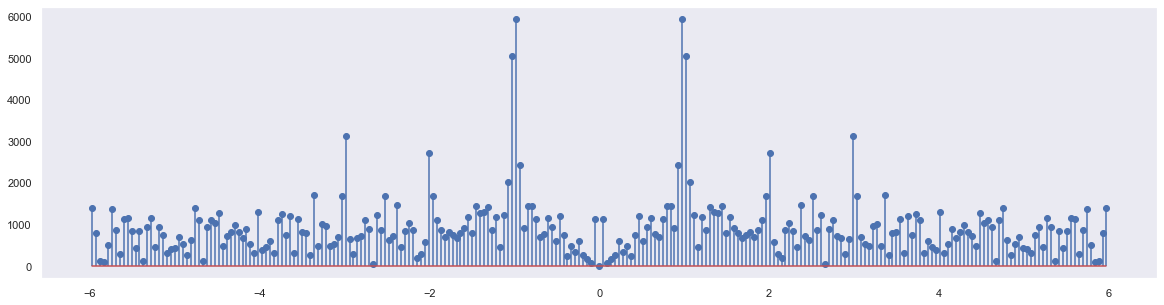

In [139]:
precip_ts = climate[climate.polygon_id==8].sort_values('datetime').precipitation.to_numpy()
y_fft = fftpack.fft(precip_ts- precip_ts.mean())
xf = fftfreq(257, 1/12)
plt.stem(xf, np.abs(y_fft))
plt.show()